<a href="https://colab.research.google.com/github/KatBotkowska/CodersCrew/blob/master/Netflix_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importy

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 13.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617607 sha256=bdabf3d7231dae6d737fcc6529fd3d8706a75f589712532bef88bb43ef55af41
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader, KNNBasic

In [2]:
#podłączenie google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
root_path = '/content/gdrive/MyDrive/CodersCrew'

In [22]:
cd '/content/gdrive/MyDrive/CodersCrew'

/content/gdrive/My Drive/CodersCrew


##Pobranie i rozpakowanie danych kaggle - IMDb

###pobranie danych z kaggle - nie odpalać!

In [23]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kbotkowska","key":"90ebb11108c952959800f5549af3472d"}'}

In [24]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [25]:
!kaggle datasets download -d stefanoleone992/imdb-extensive-dataset

 95% 78.0M/82.3M [00:00<00:00, 155MB/s]
100% 82.3M/82.3M [00:00<00:00, 153MB/s]


In [34]:
!unzip -q imdb-extensive-dataset.zip -d CodersCrew

###Dane

In [35]:
imdb_movies = pd.read_csv('/content/gdrive/MyDrive/CodersCrew/CodersCrew/IMDb movies.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
imdb_movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [ ]:
imdb_movies.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

##Czyszczenie danych


###zamiana wiersza z TV movie 2019 na 2019
dtypes z object na właściwe
NaN??
gatunki zamiana ze stringa na listy tagów - TUTAJ?

In [38]:
imdb_movies.dtypes

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [39]:
imdb_movies[imdb_movies.year == 'TV Movie 2019']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
83917,tt8206668,Bad Education,Bad Education,TV Movie 2019,TV Movie 2019,"Biography, Comedy, Crime",108,USA,English,Cory Finley,"Mike Makowsky, Robert Kolker",HBO Films,"Hugh Jackman, Ray Romano, Welker White, Alliso...",The beloved superintendent of New York's Rosly...,7.1,23973,NaN,NaN,NaN,79.0,135.0,98.0


In [40]:
imdb_movies.loc[83917, 'year'] = 2019
imdb_movies.year = imdb_movies.year.astype('int')
imdb_movies.dtypes

imdb_title_id             object
title                     object
original_title            object
year                       int64
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

###Wyczyszenie kolumn dotyczących dochodu - worlwide_gross_income - object z NaN, dodatkowo nazwa waluty przy kwotach

In [41]:
imdb_movies['worlwide_gross_income']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
85850    $ 3507171
85851    $ 7299062
85852          NaN
85853       $ 2833
85854      $ 59794
Name: worlwide_gross_income, Length: 85855, dtype: object

In [42]:
#Wyczyszczenie NaN
imdb_movies['worlwide_gross_income'].replace(np.nan, '$ 0', inplace=True)

In [43]:
#poprzez split oddzielenie waluty od wartości
imdb_movies['worlwide_gross_income']=imdb_movies['worlwide_gross_income'].apply(lambda x: x.split())


In [44]:
#Wydzielenie walut do osobnej kolumny
imdb_movies['currency_for_wwincome']=imdb_movies['worlwide_gross_income'].apply(lambda x: x[0])

In [45]:
#Waluty występujące w worlwide gross income
imdb_movies['currency_for_wwincome'].unique()

array(['$', 'GBP', 'INR', 'NPR', 'PKR'], dtype=object)

In [46]:
#kolumna z worlwide gross income tylko z wartościami
imdb_movies['worlwide_gross_income']=imdb_movies['worlwide_gross_income'].apply(lambda x: x[1])

In [47]:
#zmiana stringów na int
imdb_movies['worlwide_gross_income']=imdb_movies['worlwide_gross_income'].astype(int)

In [48]:
#zmiana typu z obj na int
imdb_movies['worlwide_gross_income'] =imdb_movies['worlwide_gross_income'].astype(int)

In [49]:
imdb_movies['worlwide_gross_income']

0              0
1              0
2              0
3              0
4              0
          ...   
85850    3507171
85851    7299062
85852          0
85853       2833
85854      59794
Name: worlwide_gross_income, Length: 85855, dtype: int64

In [50]:
imdb_movies['currency_for_wwincome']

0        $
1        $
2        $
3        $
4        $
        ..
85850    $
85851    $
85852    $
85853    $
85854    $
Name: currency_for_wwincome, Length: 85855, dtype: object

###Wyczyszczenie kolumn dotyczących dochodu w USA - USA_gross_income - object z NaN, nazwy waluty przy kwotach


In [51]:
imdb_movies['usa_gross_income']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
85850    NaN
85851    NaN
85852    NaN
85853    NaN
85854    NaN
Name: usa_gross_income, Length: 85855, dtype: object

In [52]:
#Wyczyszczenie NaN
imdb_movies['usa_gross_income'].replace(np.nan, '$ 0', inplace=True)

In [53]:
#poprzez split oddzielenie waluty od wartości
imdb_movies['usa_gross_income']=imdb_movies['usa_gross_income'].apply(lambda x: x.split())


In [54]:
#Wydzielenie walut do osobnej kolumny
imdb_movies['currency_for_usaincome']=imdb_movies['usa_gross_income'].apply(lambda x: x[0])

In [55]:
#Waluty występujące w USA gross income
imdb_movies['currency_for_usaincome'].unique()

array(['$', 'EUR', 'GBP', 'HKD'], dtype=object)

In [56]:
#kolumna z USA gross income tylko z wartościami
imdb_movies['usa_gross_income']=imdb_movies['usa_gross_income'].apply(lambda x: x[1])

In [57]:
#zmiana stringów na int
imdb_movies['usa_gross_income']=imdb_movies['usa_gross_income'].astype(int)

In [58]:
#zmiana typu z obj na int
imdb_movies['usa_gross_income'] =imdb_movies['usa_gross_income'].astype(int)

In [59]:
imdb_movies['usa_gross_income']

0        0
1        0
2        0
3        0
4        0
        ..
85850    0
85851    0
85852    0
85853    0
85854    0
Name: usa_gross_income, Length: 85855, dtype: int64

In [60]:
imdb_movies['currency_for_usaincome']

0        $
1        $
2        $
3        $
4        $
        ..
85850    $
85851    $
85852    $
85853    $
85854    $
Name: currency_for_usaincome, Length: 85855, dtype: object

###Wyczyszczenie kolumn dotyczących budżetu filmów - budget - obj z NaN, waluty przy wartościach

In [61]:
imdb_movies['budget']

0            NaN
1         $ 2250
2            NaN
3        $ 45000
4            NaN
          ...   
85850        NaN
85851        NaN
85852        NaN
85853        NaN
85854        NaN
Name: budget, Length: 85855, dtype: object

In [62]:
#Wyczyszczenie NaN
imdb_movies['budget'].replace(np.nan, '$ 0', inplace=True)

In [63]:
#poprzez split oddzielenie waluty od wartości
imdb_movies['budget']=imdb_movies['budget'].apply(lambda x: x.split())


In [64]:
#Wydzielenie walut do osobnej kolumny
imdb_movies['currency_for_budget']=imdb_movies['budget'].apply(lambda x: x[0])

In [65]:
#Waluty występujące w budget
imdb_movies['currency_for_budget'].unique()

array(['$', 'ITL', 'ROL', 'SEK', 'FRF', 'NOK', 'GBP', 'DEM', 'PTE', 'FIM',
       'CAD', 'INR', 'CHF', 'ESP', 'JPY', 'DKK', 'NLG', 'PLN', 'RUR',
       'AUD', 'KRW', 'BEF', 'XAU', 'HKD', 'NZD', 'CNY', 'EUR', 'PYG',
       'ISK', 'IEP', 'TRL', 'HRK', 'SIT', 'PHP', 'HUF', 'DOP', 'JMD',
       'CZK', 'SGD', 'BRL', 'BDT', 'ATS', 'BND', 'EGP', 'THB', 'GRD',
       'ZAR', 'NPR', 'IDR', 'PKR', 'MXN', 'BGL', 'EEK', 'YUM', 'MYR',
       'IRR', 'CLP', 'SKK', 'LTL', 'TWD', 'MTL', 'LVL', 'COP', 'ARS',
       'UAH', 'RON', 'ALL', 'NGN', 'ILS', 'VEB', 'VND', 'TTD', 'JOD',
       'LKR', 'GEL', 'MNT', 'AZM', 'AMD', 'AED'], dtype=object)

In [66]:
#kolumna z budget tylko z wartościami
imdb_movies['budget']=imdb_movies['budget'].apply(lambda x: x[1])

In [67]:
#zmiana stringów na int
imdb_movies['budget']=imdb_movies['budget'].astype(int)

In [68]:
#zmiana typu z obj na int
imdb_movies['budget'] =imdb_movies['budget'].astype(int)

In [69]:
imdb_movies['budget']

0            0
1         2250
2            0
3        45000
4            0
         ...  
85850        0
85851        0
85852        0
85853        0
85854        0
Name: budget, Length: 85855, dtype: int64

In [70]:
imdb_movies['currency_for_budget']

0        $
1        $
2        $
3        $
4        $
        ..
85850    $
85851    $
85852    $
85853    $
85854    $
Name: currency_for_budget, Length: 85855, dtype: object

# Jak przez lata zmieniała się liczba wydawanych filmów? - Ewa

In [71]:
imdb_movies.groupby('year').imdb_title_id.count()

year
1894       1
1906       1
1911       5
1912       5
1913      13
        ... 
2016    3138
2017    3329
2018    3257
2019    2842
2020     789
Name: imdb_title_id, Length: 112, dtype: int64

In [72]:
data_year_plot = imdb_movies.groupby('year').imdb_title_id.count()
data_year_plot.tail(20)

year
2001    1447
2002    1405
2003    1496
2004    1681
2005    1827
2006    2063
2007    2074
2008    2175
2009    2298
2010    2281
2011    2429
2012    2560
2013    2783
2014    2942
2015    2977
2016    3138
2017    3329
2018    3257
2019    2842
2020     789
Name: imdb_title_id, dtype: int64

## Lata 1894-2020

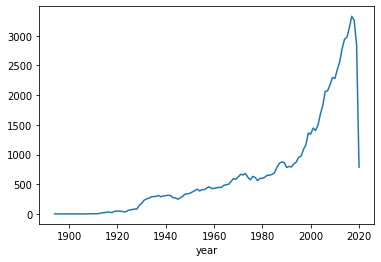

In [73]:
data_year_plot.plot()
plt.show()

## Lata 1894-2009

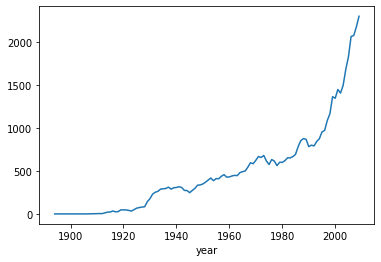

In [74]:
data_year_plot_to2009 = imdb_movies[imdb_movies.year <= 2009].groupby('year').imdb_title_id.count()
data_year_plot_to2009.plot()

## Lata 2005-2019

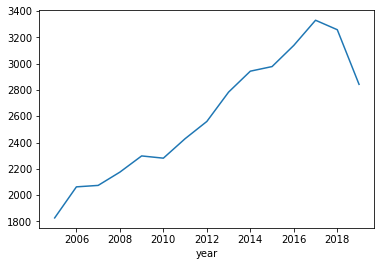

In [75]:
#Wykres bez roku 2020, ze względu na niepełne dane
data_year_plot_from2004_to2019 = imdb_movies[(imdb_movies.year > 2004) & (imdb_movies.year<2020)].groupby('year').imdb_title_id.count()
data_year_plot_from2004_to2019.plot()

# Jakie gatunki filmów są najpopularniejsze? - Kasia

##Najczęściej występujące gatunki

In [76]:
imdb_movies['genre'].value_counts().head(10)

Drama                     12543
Comedy                     7693
Comedy, Drama              4039
Drama, Romance             3455
Comedy, Romance            2508
Comedy, Drama, Romance     2293
Horror                     2268
Drama, Thriller            1348
Crime, Drama               1343
Action, Crime, Drama       1310
Name: genre, dtype: int64

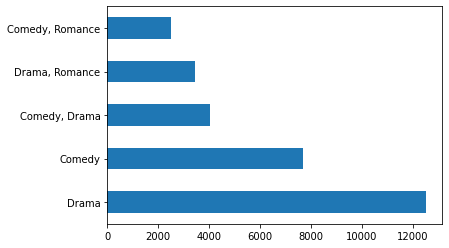

In [77]:
ax = imdb_movies['genre'].value_counts().head().plot.barh(rot=0)

##Liczba gatunków w poszczególnych latach
Widać, że gatunki to 'tagi' opisujące film, do jednego filmu przypisuje się coraz więcej gatunków.

In [78]:
#Liczba gatunków filmów w poszczególnych latach
imdb_movies.groupby('year').genre.nunique().tail(20)

year
2001    279
2002    253
2003    273
2004    288
2005    272
2006    262
2007    270
2008    258
2009    272
2010    271
2011    285
2012    293
2013    295
2014    316
2015    310
2016    287
2017    318
2018    323
2019    278
2020    172
Name: genre, dtype: int64

##Lista wszystkich gatunków

In [79]:
genres = imdb_movies['genre'].unique().tolist()
genres_all=[]
for genre in genres:
    for elem in genre.split(','):
        genres_all.append(elem.strip())
genres_all=list(set(genres_all))
genres_all

['Sport',
 'Reality-TV',
 'History',
 'Adventure',
 'Horror',
 'Thriller',
 'Mystery',
 'Western',
 'Family',
 'Drama',
 'Sci-Fi',
 'Animation',
 'Adult',
 'Romance',
 'Musical',
 'News',
 'Action',
 'Biography',
 'Music',
 'Comedy',
 'War',
 'Documentary',
 'Film-Noir',
 'Crime',
 'Fantasy']

##Unikalne gatunki - najbardziej popularne

In [80]:
genres = imdb_movies['genre'].tolist()
genres_count=[]
for genre in genres:
    for elem in genre.split(','):
        genres_all.append(elem.strip())
genres_count=list(genres_all)
from collections import Counter
genres_count_all=pd.DataFrame.from_dict(Counter(genres_count), orient='index')
genres_count_all.rename(columns={'index':'genres', 0:'occurences'}, inplace=True)
genres_count_all.sort_values(by='occurences', ascending=False)


,occurences
Drama,47111
Comedy,29369
Romance,14129
Action,12949
Thriller,11389
Crime,11068
Horror,9558
Adventure,7591
Mystery,5226
Family,3963


Text(0.5, 0, 'occurences')

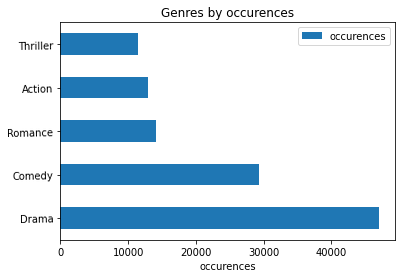

In [81]:
ax = genres_count_all.sort_values(by='occurences', ascending=False).head().plot.barh(rot=1, title='Genres by occurences')
ax.set_xlabel('occurences')
#ax.set_ylabel()


## Najpopularniejsze gatunki filmów według lat


In [82]:
imdb_movies['genre_list']=imdb_movies['genre'].str.split(',', n=5)

In [83]:
genres_by_years=imdb_movies[['genre', 'year']].groupby(['year', 'genre'], as_index=True)['genre'].count()
genres_by_years.tail(100)

year  genre                     
2020  Biography, Drama, Thriller     1
      Biography, Music               2
      Comedy                        75
      Comedy, Crime                  4
      Comedy, Crime, Drama           4
                                    ..
      Sci-Fi, Thriller               2
      Sport                          1
      Thriller                      37
      War                            3
      Western                        2
Name: genre, Length: 100, dtype: int64

In [84]:
#dla roku 2019 zamiana str gatunków na listę
genres_split_by_years=imdb_movies[['genre', 'year', 'imdb_title_id']]
#genres_split_by_years[genres_split_by_years['year']==2019]
genres = genres_split_by_years['genre']
new_genres=[]
for genre in genres.to_list():
    genre = genre.split(',')
    new_genres.append(genre)

genres_split_by_years['new_genre']=new_genres
genres_split_by_years


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,genre,year,imdb_title_id,new_genre
0,Romance,1894,tt0000009,[Romance]
1,"Biography, Crime, Drama",1906,tt0000574,"[Biography, Crime, Drama]"
2,Drama,1911,tt0001892,[Drama]
3,"Drama, History",1912,tt0002101,"[Drama, History]"
4,"Adventure, Drama, Fantasy",1911,tt0002130,"[Adventure, Drama, Fantasy]"
...,...,...,...,...
85850,Comedy,2020,tt9908390,[Comedy]
85851,"Comedy, Drama",2020,tt9911196,"[Comedy, Drama]"
85852,Drama,2019,tt9911774,[Drama]
85853,"Drama, Family",2019,tt9914286,"[Drama, Family]"


In [85]:
genres_in_2019 = genres_split_by_years[genres_split_by_years['year']==2019]
genres_2019=genres_in_2019['new_genre'].to_list()
genres_2019[:20]

[['Crime', ' Drama', ' Mystery'],
 ['Action', ' Adventure', ' Sci-Fi'],
 ['Action', ' Drama', ' War'],
 ['Action', ' Adventure', ' Comedy'],
 ['Drama', ' War'],
 ['Biography', ' Comedy', ' Drama'],
 ['Crime', ' Drama', ' Romance'],
 ['Horror', ' Mystery', ' Thriller'],
 ['Drama'],
 ['Drama'],
 ['Family', ' Romance'],
 ['Comedy'],
 ['Drama'],
 ['Comedy', ' Horror', ' Sci-Fi'],
 ['Comedy', ' Drama'],
 ['Comedy', ' Drama'],
 ['Music'],
 ['Action', ' Comedy', ' Horror'],
 ['Horror'],
 ['Drama', ' Romance']]

In [86]:
genres_count=[]
genres_all=[]
for genres in genres_2019:
    for genre in genres:
        genres_all.append(genre.strip())
genres_count_2019=list(genres_all)
from collections import Counter
genres_count_all_2019=pd.DataFrame.from_dict(Counter(genres_count_2019), orient='index')
genres_count_all_2019.rename(columns={'index':'genres', 0:'occurences'}, inplace=True)

genres_count_all_2019.sort_values(by='occurences', ascending=False)

,occurences
Drama,1530
Comedy,871
Thriller,503
Action,460
Horror,383
Romance,312
Crime,306
Adventure,206
Mystery,185
Family,141


In [87]:
#Genres by years

table={}
years = [2010, 2011, 2012,2013,2014,2015,2016, 2017,2018,2019]
genres = ['Drama', 'Comedy', 'Romance', 'Action', 'Thriller','Crime', 'Horror']

for year in years:

    genres_in_year = genres_split_by_years[genres_split_by_years['year']==year]['new_genre']
    genres_in_year=[item.strip() for sublist in genres_in_year for item in sublist]
    table[year]={}
    for genre in genres: ##genres_all nie działa???
        table[year][genre]=genres_in_year.count(genre)

genres_in_years = pd.DataFrame(table)
genres_in_years
   



,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Drama,1305,1386,1371,1501,1572,1621,1707,1812,1708,1530
Comedy,755,813,902,923,1006,987,1040,1040,1035,871
Romance,337,350,344,426,455,433,423,410,392,312
Action,378,379,371,408,441,454,516,524,493,460
Thriller,371,368,415,512,527,552,578,595,552,503
Crime,253,245,249,276,295,268,332,342,304,306
Horror,299,303,362,402,454,475,452,497,476,383


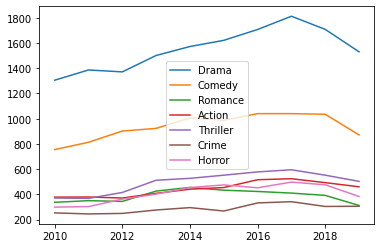

In [88]:
genres_in_years.T.plot()

# Jakie kraje dominują w produkcji filmów  - które wypuszczają najwięcej filmów, i z 5 największych zrobić szeregi czasowe - GRZESIEK

In [89]:
''' 
Po pierwsze, te kraje są bardzo dziwne. Po drugie nie jestem 
w stanie określić która firma produkcyjna należy do danego kraju. 
Po trzecie te wszystkie kraje pokazują gdzie filmy zostały nakręcone.
'''
imdb_movies['country'].value_counts().head(10)

USA          28511
India         6065
UK            4111
Japan         3077
France        3055
Italy         2444
Canada        1802
Germany       1396
Turkey        1351
Hong Kong     1239
Name: country, dtype: int64

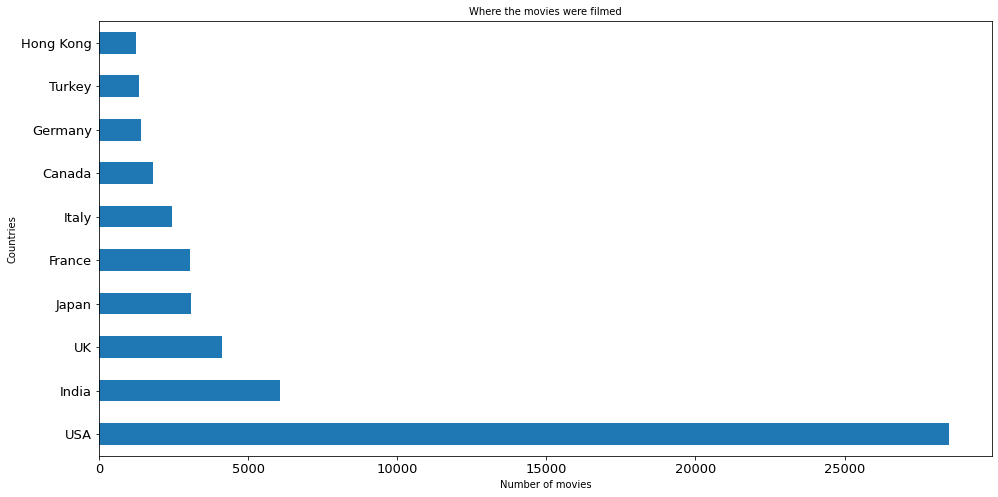

In [90]:
'''
Te wykresy są okej, ale później jest coś nie tak...
'''
chart_country = imdb_movies['country'].value_counts().head(10)
chart_country.plot(kind='barh', figsize=(16,8), fontsize=13)
plt.title("Where the movies were filmed", fontsize=10)
plt.xlabel('Number of movies')
plt.ylabel('Countries')
plt.show()

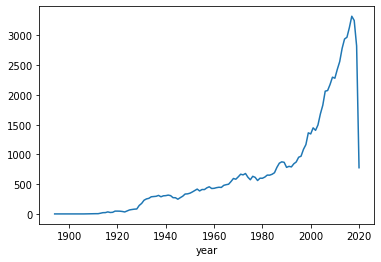

In [91]:
imdb_movies.groupby('year').country.count().plot()

In [92]:
countries_new = imdb_movies[['year', 'country']]
countries_new

,year,country
0,1894,USA
1,1906,Australia
2,1911,"Germany, Denmark"
3,1912,USA
4,1911,Italy
...,...,...
85850,2020,"France, Belgium"
85851,2020,Netherlands
85852,2019,India
85853,2019,Turkey


In [93]:
'''
Teraz sprawdzam produkcję filmu. Jak widać że czołowe firmy należą do USA oprócz Mosfilm i Canal+.
'''
imdb_movies['production_company'].value_counts().head(20)

Metro-Goldwyn-Mayer (MGM)                1284
Warner Bros.                             1153
Columbia Pictures                         914
Paramount Pictures                        903
Twentieth Century Fox                     865
Universal Pictures                        732
RKO Radio Pictures                        535
Mosfilm                                   279
Universal International Pictures (UI)     272
Canal+                                    231
Republic Pictures (I)                     208
New Line Cinema                           205
CJ Entertainment                          175
Shaw Brothers                             169
Toho Company                              158
First National Pictures                   155
Shochiku                                  144
Golden Harvest Company                    140
Touchstone Pictures                       140
Lenfilm Studio                            137
Name: production_company, dtype: int64

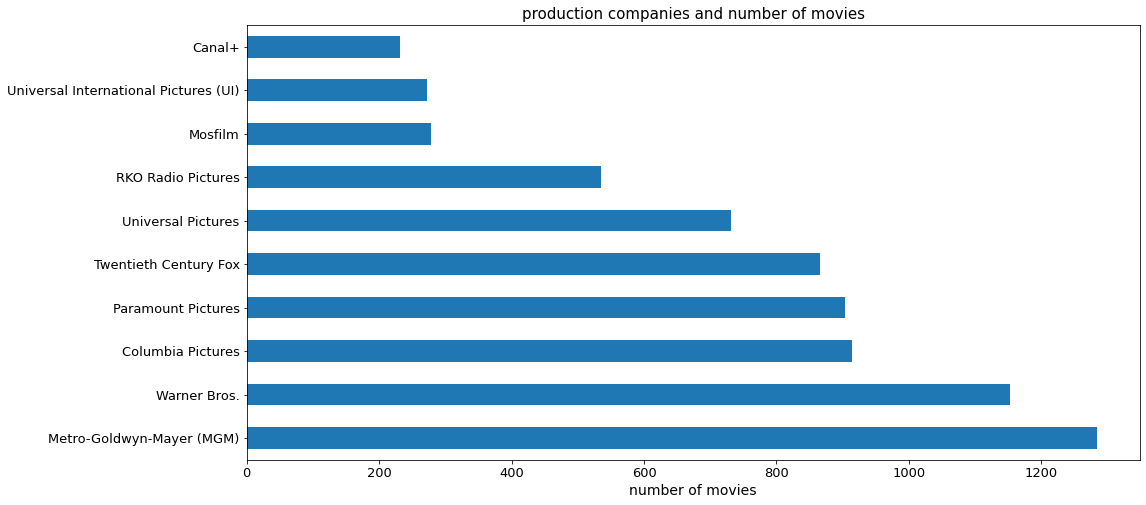

In [94]:
imdb_production = imdb_movies['production_company'].value_counts()
imdb_production.iloc[:10].plot(kind='barh',figsize=(16,8),fontsize=13)
plt.title("production companies and number of movies",fontsize=15)
plt.xlabel('number of movies',fontsize=14)
sn.set_style("whitegrid")

In [95]:
'''
Tutaj niestety jest za mało kolumn żeby określić w których krajach produkowali najwięcej 
filmów, więc sprawdzam które produkcje filmowe zostały najlepiej ocenione.
'''
imdb_movies.corr()

,year,duration,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
year,1.000000,0.172810,-0.217559,0.058559,0.014228,0.060783,0.082185,-0.183089,0.070624,0.138014
duration,0.172810,1.000000,0.242432,0.125618,0.010798,0.099893,0.112783,0.210531,0.130836,0.135465
avg_vote,-0.217559,0.242432,1.000000,0.166972,-0.004513,0.104801,0.098050,0.691338,0.138185,0.200526
votes,0.058559,0.125618,0.166972,1.000000,0.004387,0.703496,0.662827,0.194730,0.766237,0.671635
budget,0.014228,0.010798,-0.004513,0.004387,1.000000,0.004543,0.006731,0.005449,0.012036,0.009339
usa_gross_income,0.060783,0.099893,0.104801,0.703496,0.004543,1.000000,0.917454,0.065852,0.657322,0.600560
worlwide_gross_income,0.082185,0.112783,0.098050,0.662827,0.006731,0.917454,1.000000,0.063352,0.630510,0.572743
metascore,-0.183089,0.210531,0.691338,0.194730,0.005449,0.065852,0.063352,1.000000,0.126131,0.236107
reviews_from_users,0.070624,0.130836,0.138185,0.766237,0.012036,0.657322,0.630510,0.126131,1.000000,0.671634
reviews_from_critics,0.138014,0.135465,0.200526,0.671635,0.009339,0.600560,0.572743,0.236107,0.671634,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 34.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 27.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.1% of the points cannot be placed; yo

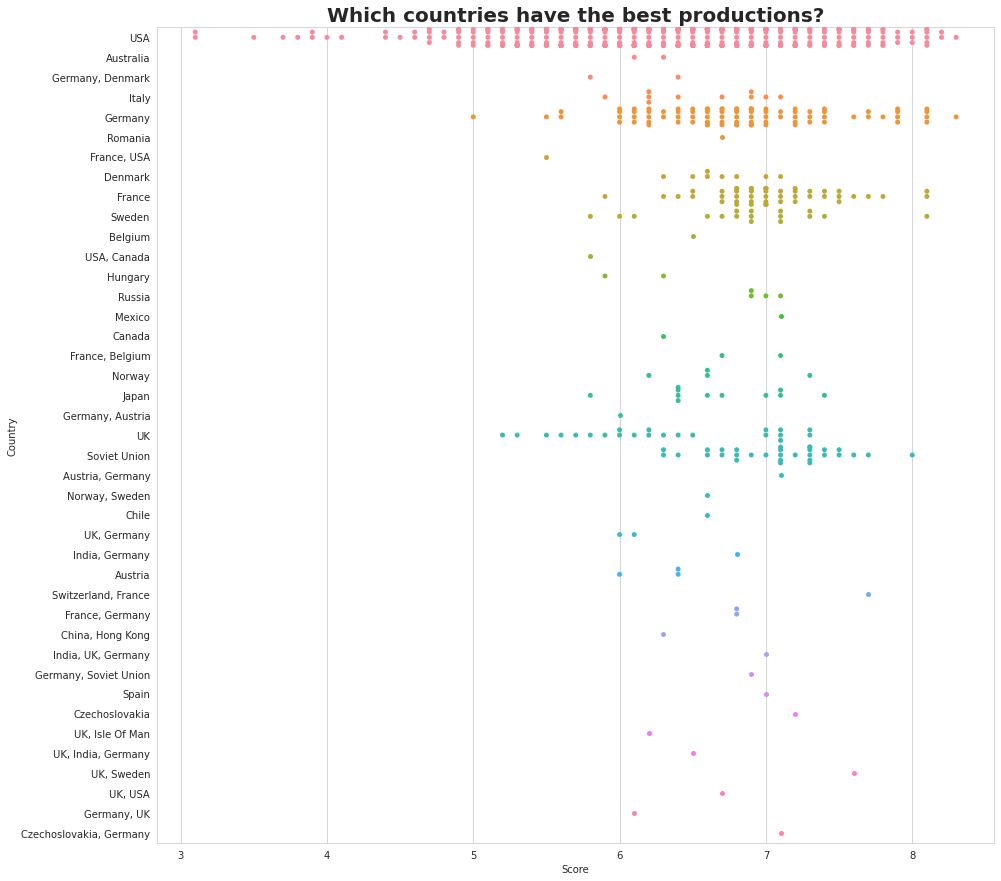

In [96]:
movie_sliced = imdb_movies[0:1000]


plt.figure(figsize=(15,15))
sn.swarmplot(x='avg_vote', y='country', data = movie_sliced)
plt.title ('Which countries have the best productions?', fontsize=20, fontweight='bold')
plt.xlabel('Score')
plt.ylabel('Country')
plt.show()

#Ile przypadków, że scenarzysta jest jednocześnie reżyserem w filmie - Ewa

In [97]:
imdb_movies[imdb_movies.writer == imdb_movies.director].director.count()
# to tak prosto, czyli odpowiada na postawione pytanie, 
# ale tylko wtedy jeśli jest jeden reżyser i jeden scenarzysta.

17797

In [98]:
imdb_movies['writer_1'] = imdb_movies.writer.str.split(pat=',', expand=True)[0]
imdb_movies['writer_2'] = imdb_movies.writer.str.split(pat=',', expand=True)[1]
imdb_movies[['writer_1', 'writer_2']]

,writer_1,writer_2
0,Alexander Black,None
1,Charles Tait,None
2,Urban Gad,Gebhard Schätzler-Perasini
3,Victorien Sardou,None
4,Dante Alighieri,None
...,...,...
85850,Alexandre Coquelle,Matthieu Le Naour
85851,Radek Bajgar,Herman Finkers
85852,Vineesh Aaradya,Vineesh Aaradya
85853,Ahmet Faik Akinci,Kasim Uçkan


In [99]:
imdb_movies['director_1'] = imdb_movies.director.str.split(pat=',', expand=True)[0]
imdb_movies['director_2'] = imdb_movies.director.str.split(pat=',', expand=True)[1]
imdb_movies[['director_1', 'director_2']]

,director_1,director_2
0,Alexander Black,None
1,Charles Tait,None
2,Urban Gad,None
3,Charles L. Gaskill,None
4,Francesco Bertolini,Adolfo Padovan
...,...,...
85850,Ludovic Colbeau-Justin,None
85851,Johan Nijenhuis,None
85852,Vineesh Aaradya,None
85853,Ahmet Faik Akinci,None


In [100]:
imdb_movies[(imdb_movies.writer_1 == imdb_movies.director_1) | 
        (imdb_movies.writer_1 == imdb_movies.director_2) | 
        (imdb_movies.writer_2 == imdb_movies.director_1) | 
        (imdb_movies.writer_2 == imdb_movies.director_2)].imdb_title_id.count()

31803

#Reżyser - z największymi średnimi głosów, największa liczba głosów - KASIA

In [101]:
#Reżyserzy z największą średnią ocen, którzy nakręcili więcej niż 5 filmów
imdb_directors_av_votes=imdb_movies[['director','avg_vote']].groupby('director').agg(['count', 'mean']).reset_index()
imdb_directors_av_votes[imdb_directors_av_votes['avg_vote']['count']>5].sort_values(by=('avg_vote','mean'), ascending=False).reset_index().head(10)

index           director avg_vote          
                               count      mean
0   5749  Christopher Nolan       11  8.218182
1  28854       Satyajit Ray       28  8.025000
2   1753   Andrei Tarkovsky        7  8.014286
3  12193     Hayao Miyazaki       12  8.008333
4  29269       Sergio Leone        7  7.928571
5  12725      Humayun Ahmed        7  7.900000
6  13739      James Cameron        7  7.885714
7  25895  Quentin Tarantino       12  7.858333
8  31398    Tengiz Abuladze        6  7.850000
9  29214          Sergey A.       24  7.850000

In [102]:
#reżyserzy, którzy kręcą dużo i źle ;)
imdb_directors_av_votes[imdb_directors_av_votes['avg_vote']['count']>10].sort_values(by=('avg_vote','mean'), ascending=True).head(10)

director avg_vote          
                          count      mean
4153       Brett Kelly       18  1.533333
26614       Rene Perez       18  2.805556
14121       Jared Cohn       16  2.943750
20607      Mark Atkins       12  3.066667
1831      Andrew Jones       24  3.241667
7102    David DeCoteau       44  3.259091
30577  Steven M. Smith       12  3.266667
6933    Daryush Shokof       11  3.318182
18975      Leigh Scott       12  3.341667
27025      Rick Sloane       11  3.400000

In [103]:
#jakie oceny dostają reżyserzy którzy idą 'na ilość'
imdb_directors_av_votes[imdb_directors_av_votes['avg_vote']['count']>5].sort_values(by=('avg_vote','count'), ascending=False).head(10)

director avg_vote          
                           count      mean
15006      Jesús Franco       87  4.718391
21840    Michael Curtiz       85  6.543529
19114   Lesley Selander       78  6.214103
19360       Lloyd Bacon       73  6.232877
33646  William Beaudine       70  5.861429
26955    Richard Thorpe       68  6.263235
15682         John Ford       67  6.710448
11306    Gordon Douglas       64  6.175000
26370       Raoul Walsh       61  6.590164
21702      Mervyn LeRoy       59  6.689831

In [104]:
#Reżyserzy których filmy otrzymują średnio najwięcej głosów, którzy nakręcili więcej niż 5 filmów
imdb_directors_sum_votes=imdb_movies[['director','votes']].groupby('director').agg(['count', 'sum']).reset_index()
imdb_directors_sum_votes['votes_per_film'] = imdb_directors_sum_votes['votes']['sum']/imdb_directors_sum_votes['votes']['count']
imdb_directors_sum_votes['votes_per_film']=imdb_directors_sum_votes['votes_per_film'].astype('int')
imdb_directors_sum_votes[imdb_directors_sum_votes['votes']['count']>5].sort_values(by=('votes_per_film'), ascending=False).head(10)

director votes           votes_per_film
                                       count       sum               
5749                 Christopher Nolan    11  11653144        1059376
25895                Quentin Tarantino    12   8458703         704891
13739                    James Cameron     7   4915763         702251
7141                     David Fincher    10   6944421         694442
25197                    Peter Jackson    13   7304418         561878
10749                     George Lucas     6   3364510         560751
2353          Anthony Russo, Joe Russo     6   3006253         501042
13336                      J.J. Abrams     6   2881528         480254
18639  Lana Wachowski, Lilly Wachowski     6   2871445         478574
34464                      Zack Snyder     8   3410835         426354

#Scenarzysta - jw - GRZESIEK

In [105]:
imdb_writers_av_votes=imdb_movies[['writer','avg_vote']].groupby('writer').agg(['count', 'mean']).reset_index()
imdb_writers_av_votes[imdb_writers_av_votes['avg_vote']['count']>10].sort_values(by=('avg_vote','mean'), ascending=False).reset_index().head(10)

index               writer avg_vote          
                                 count      mean
0  65706         Yavuz Turgul       12  7.783333
1  56788            Sergey A.       15  7.746667
2     74      A.K. Lohithadas       20  7.655000
3   9589      Charles Chaplin       13  7.646154
4  65095  William Shakespeare       25  7.608000
5  25612       Ingmar Bergman       27  7.540741
6  58438          Sreenivasan       19  7.510526
7  61641       Titus Popovici       14  7.500000
8   5751        Bahram Beizai       11  7.472727
9  38874  M.T. Vasudevan Nair       12  7.441667

In [106]:
imdb_writers_av_votes[imdb_writers_av_votes['avg_vote']['count']>10].sort_values(by=('avg_vote','mean'), ascending=True).head(10)

writer avg_vote          
                                        count      mean
3368                    Andrew Jones       20  3.250000
10348                     Chris Hyde       11  3.790909
45413          Neal Marshall Stevens       12  4.075000
54066                 Rolfe Kanefsky       13  4.153846
13240                 David A. Prior       12  4.300000
29641     Jesús Franco, Jesús Franco       21  4.461905
26964                   Jake Helgren       11  4.581818
8878   Carlo Vanzina, Enrico Vanzina       32  4.656250
40081                 Mariano Ozores       11  4.800000
21481                Giannis Sklavos       15  4.806667

In [107]:
imdb_writers_av_votes[imdb_writers_av_votes['avg_vote']['count']>5].sort_values(by=('avg_vote','count'), ascending=False).head(10)

writer avg_vote          
                                                count      mean
29999                              Jing Wong       84  5.664286
35968                               Kuang Ni       45  6.448889
65383                            Woody Allen       40  6.962500
17334                          Erdogan Tünas       35  5.782857
37295  Leonardo Benvenuti, Piero De Bernardi       34  6.441176
8878           Carlo Vanzina, Enrico Vanzina       32  4.656250
9968                    Cheh Chang, Kuang Ni       31  6.732258
21466                     Giannis Dalianidis       29  6.051724
55241                              Safa Önal       27  6.288889
25612                         Ingmar Bergman       27  7.540741

In [108]:
imdb_writers_sum_votes=imdb_movies[['writer','votes']].groupby('writer').agg(['count', 'sum']).reset_index()
imdb_writers_sum_votes['votes_per_film'] = imdb_writers_sum_votes['votes']['sum']/imdb_writers_sum_votes['votes']['count']
imdb_writers_sum_votes['votes_per_film']=imdb_writers_sum_votes['votes_per_film'].astype('int')
imdb_writers_sum_votes[imdb_writers_sum_votes['votes']['count']>5].sort_values(by=('votes_per_film'), ascending=False).head(10)

writer votes          votes_per_film
                                           count      sum               
50296                    Quentin Tarantino     6  4020378         670063
10874  Christopher Markus, Stephen McFeely     8  3992065         499008
37682      Lilly Wachowski, Lana Wachowski     8  3957627         494703
19029          Fran Walsh, Philippa Boyens     6  2439951         406658
51745            Rhett Reese, Paul Wernick     6  2352446         392074
53518            Robert Zemeckis, Bob Gale     6  1937286         322881
3420                         Andrew Niccol     7  1956048         279435
13287                           David Ayer     6  1675039         279173
38834                   M. Night Shyamalan    12  3002774         250231
38274        Luc Besson, Robert Mark Kamen    10  2200519         220051

#Reżyser - dochód z filmów - Kasia

##Reżyserzy z największą ilością filmów

In [109]:
#Reżyserzy z największą liczbą filmów
imdb_movies['director'].value_counts().head(10)

Jesús Franco        87
Michael Curtiz      85
Lesley Selander     78
Lloyd Bacon         73
William Beaudine    70
Richard Thorpe      68
John Ford           67
Gordon Douglas      64
Raoul Walsh         61
Mervyn LeRoy        59
Name: director, dtype: int64

##Reżyserzy, których filmy osiągnęły największy dochód na świecie - dot. dochodów podanych w USD

In [110]:
#nowa df z danymi gdzie worlwide_gross_income w dolarach
imdb_movies_USD_wwincome = imdb_movies[imdb_movies['currency_for_wwincome']=='$']

In [111]:
#Reżyserzy z największym dochodem w dolarach-dochód z wszystkich filmów
imdb_director_worlwide_income=imdb_movies_USD_wwincome.groupby('director').agg({'imdb_title_id':'count','worlwide_gross_income':'sum'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='worlwide_gross_income', ascending=False)
imdb_director_worlwide_income['worlwide_gross_income']=imdb_director_worlwide_income['worlwide_gross_income']/1000000
imdb_director_worlwide_income['worlwide_gross_income'] = round(imdb_director_worlwide_income['worlwide_gross_income'],2)
imdb_director_worlwide_income.columns = ['director', 'films_count', 'worlwide_gross_income_in_mln']
imdb_director_worlwide_income.head(20)

,director,films_count,worlwide_gross_income_in_mln
30601,Steven Spielberg,32,10521.27
2352,"Anthony Russo, Joe Russo",6,6848.72
25192,Peter Jackson,13,6601.46
21769,Michael Bay,14,6451.69
13738,James Cameron,7,6185.44
7486,David Yates,8,6021.26
5748,Christopher Nolan,11,4870.77
13335,J.J. Abrams,6,4653.99
27840,Ron Howard,25,4390.73
16072,Jon Favreau,9,4348.73


In [112]:
#średni dochód z filmów na świecie
imdb_director_worlwide_income['average_worlwide_income_in_mln']=imdb_director_worlwide_income['worlwide_gross_income_in_mln']/imdb_director_worlwide_income['films_count']
imdb_director_worlwide_income['average_worlwide_income_in_mln']=imdb_director_worlwide_income['average_worlwide_income_in_mln'].astype(int)
imdb_director_worlwide_income.sort_values(by='average_worlwide_income_in_mln', ascending=False).head()

,director,films_count,worlwide_gross_income_in_mln,average_worlwide_income_in_mln
5362,"Chris Buck, Jennifer Lee",2,2730.83,1365
2352,"Anthony Russo, Joe Russo",6,6848.72,1141
18500,"Kyle Balda, Pierre Coffin",2,2194.24,1097
16531,Josh Cooley,1,1073.39,1073
18950,Lee Unkrich,1,1066.97,1066


##Bollywood

In [113]:
##Bolywood
#nowa df z danymi gdzie worlwide_gross_income w rupii indyjskiej 
imdb_movies_INR = imdb_movies[imdb_movies['currency_for_wwincome']=='INR']

In [114]:
#Reżyserzy z największym dochodem w rupii indyjskiej
imdb_movies_INR.groupby('director').agg({'imdb_title_id':'count','worlwide_gross_income':'sum'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='worlwide_gross_income', ascending=False).head(10)

,director,films_count,worlwide_gross_income
29,Puri Jagannadh,3,1330300000
28,Prem,1,1300000000
26,P. Vasu,2,923400000
15,K.S. Ravikumar,2,740000000
44,Thiru,1,740000000
17,Kishore Kumar Pardasani,1,660100000
4,Alphonse Puthren,1,600000000
51,Vignesh Shivan,1,550000000
36,Satish Vegesna,1,530500000
12,Hari,1,510000000


##Reżyserzy - dochód z filmów w USA

In [115]:
imdb_movies[imdb_movies['usa_gross_income'].notnull()].head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,currency_for_wwincome,currency_for_usaincome,currency_for_budget,genre_list,writer_1,writer_2,director_1,director_2
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,0,0,0,NaN,1.0,2.0,$,$,$,[Romance],Alexander Black,None,Alexander Black,None
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,2250,0,0,NaN,7.0,7.0,$,$,$,"[Biography, Crime, Drama]",Charles Tait,None,Charles Tait,None
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,0,0,0,NaN,5.0,2.0,$,$,$,[Drama],Urban Gad,Gebhard Schätzler-Perasini,Urban Gad,None
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,45000,0,0,NaN,25.0,3.0,$,$,$,"[Drama, History]",Victorien Sardou,None,Charles L. Gaskill,None
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,0,0,0,NaN,31.0,14.0,$,$,$,"[Adventure, Drama, Fantasy]",Dante Alighieri,None,Francesco Bertolini,Adolfo Padovan


In [116]:
#nowa df z danymi gdzie usa_gross_income w dolarach
imdb_movies_USD_usaincome = imdb_movies[imdb_movies['currency_for_usaincome']=='$']

In [117]:
#Reżyserzy z największym dochodem w dolarach
imdb_director_USA_income = imdb_movies_USD_usaincome.groupby('director').agg({'imdb_title_id':'count','usa_gross_income':'sum'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='usa_gross_income', ascending=False).head(20)
imdb_director_USA_income

,director,films_count,usa_gross_income
30607,Steven Spielberg,32,4510254035
21771,Michael Bay,14,2326509503
2353,"Anthony Russo, Joe Russo",6,2281004133
13336,J.J. Abrams,6,2199407427
25197,Peter Jackson,13,2134677462
27845,Ron Howard,25,2106835706
5749,Christopher Nolan,11,2006601194
6005,Clint Eastwood,38,1978448340
13739,James Cameron,7,1950027629
27526,Robert Zemeckis,18,1949943723


In [118]:
#średni dochód z filmów w USA
imdb_director_USA_income['average_USA_income']=imdb_director_USA_income['usa_gross_income']/imdb_director_USA_income['films_count']
imdb_director_USA_income['average_USA_income']=imdb_director_USA_income['average_USA_income'].astype(int)
imdb_director_USA_income.sort_values(by='average_USA_income', ascending=False).head(15)

,director,films_count,usa_gross_income,average_USA_income
2353,"Anthony Russo, Joe Russo",6,2281004133,380167355
13336,J.J. Abrams,6,2199407427,366567904
10749,George Lucas,6,1743927501,290654583
13739,James Cameron,7,1950027629,278575375
7487,David Yates,8,1792652412,224081551
9950,Francis Lawrence,7,1481481244,211640177
16073,Jon Favreau,9,1879970186,208885576
5749,Christopher Nolan,11,2006601194,182418290
21771,Michael Bay,14,2326509503,166179250
25197,Peter Jackson,13,2134677462,164205958


##Reżyserzy - dochód na swiecie i w USA

In [119]:
#Reżyserzy z największym średnim dochodem na film w dolarach (tam gdzie i dochód na świecie i dochód w USA jest w $)
imdb_movies_income_USD = imdb_movies[imdb_movies.currency_for_usaincome.eq('$') & imdb_movies.currency_for_wwincome.eq('$')]
imdb_average_income = imdb_movies_income_USD.groupby('director').agg({'imdb_title_id':'count','usa_gross_income':'mean', 'worlwide_gross_income':'mean'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='worlwide_gross_income', ascending=False)
imdb_average_income['usa_gross_income'] = imdb_average_income['usa_gross_income'].astype(int)
imdb_average_income['worlwide_gross_income'] = imdb_average_income['worlwide_gross_income'].astype(int)
imdb_average_income.head()


,director,films_count,usa_gross_income,worlwide_gross_income
5362,"Chris Buck, Jennifer Lee",2,439055793,1365415143
2352,"Anthony Russo, Joe Russo",6,380167355,1141452591
18500,"Kyle Balda, Pierre Coffin",2,300335035,1097121269
16531,Josh Cooley,1,434038008,1073394593
18950,Lee Unkrich,1,415004880,1066969703


##Reżyserzy - budżet filmów

In [120]:
imdb_movies[imdb_movies['budget'].notnull()].head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,currency_for_wwincome,currency_for_usaincome,currency_for_budget,genre_list,writer_1,writer_2,director_1,director_2
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,0,0,0,NaN,1.0,2.0,$,$,$,[Romance],Alexander Black,None,Alexander Black,None
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,2250,0,0,NaN,7.0,7.0,$,$,$,"[Biography, Crime, Drama]",Charles Tait,None,Charles Tait,None
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,0,0,0,NaN,5.0,2.0,$,$,$,[Drama],Urban Gad,Gebhard Schätzler-Perasini,Urban Gad,None
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,45000,0,0,NaN,25.0,3.0,$,$,$,"[Drama, History]",Victorien Sardou,None,Charles L. Gaskill,None
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,0,0,0,NaN,31.0,14.0,$,$,$,"[Adventure, Drama, Fantasy]",Dante Alighieri,None,Francesco Bertolini,Adolfo Padovan


In [121]:
#nowa df z danymi gdzie budget w dolarach
imdb_movies_USD_budget = imdb_movies[imdb_movies['currency_for_budget']=='$']

In [122]:
#Reżyserzy - średni budżet w dolarach na film
df = imdb_movies_USD_budget.groupby('director').agg({'imdb_title_id':'count','budget':'mean'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='budget', ascending=False).head(20)
df['budget'] = df['budget'].round(0)
df['budget_per_film'] = df['budget']/df['films_count']
df.reset_index().sort_values(by='films_count', ascending=False).head(20)


,index,director,films_count,budget,budget_per_film
8,2198,"Anthony Russo, Joe Russo",6,193833333.0,32305555.5
12,12488,J.J. Abrams,6,176666667.0,29444444.5
1,1773,Andrew Stanton,2,215000000.0,107500000.0
0,21783,"Nathan Greno, Byron Howard",1,260000000.0,260000000.0
11,25767,Robert Stromberg,1,180000000.0,180000000.0
18,4373,Carl Rinsch,1,175000000.0,175000000.0
17,25423,"Rob Letterman, Conrad Vernon",1,175000000.0,175000000.0
16,17791,"Lee Unkrich, Adrian Molina",1,175000000.0,175000000.0
15,23475,"Pete Docter, Bob Peterson",1,175000000.0,175000000.0
14,3915,Brian Fee,1,175000000.0,175000000.0


##Reżyserzy - dochód, budżet

In [123]:
#Reżyserzy z największym dochodem ŚREDNIM !! w dolarach plus budżet
#PROBLEM - BIERZE POD UWAGĘ TYLKO AMERYKAŃSKICH REŻYSERÓW - FILMY, DLA KTÓRYCH BUDŻET DOCHÓD NA ŚWIECIE I W USA PODANY JEST W DOLARACH
imdb_movies_all_USD = imdb_movies[imdb_movies.currency_for_usaincome.eq('$') & imdb_movies.currency_for_wwincome.eq('$') & imdb_movies.currency_for_budget.eq('$')]
df = imdb_movies_all_USD.groupby('director').agg({'imdb_title_id':'count','usa_gross_income':'mean', 'worlwide_gross_income':'mean', 'budget':'mean'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='worlwide_gross_income', ascending=False).head(20)
df['budget']=df['budget'].astype(int)
df['worlwide_gross_income'] = df['worlwide_gross_income'].astype(int)
df['usa_gross_income'] = df['usa_gross_income'].astype(int)
df['return_on_films']=df['worlwide_gross_income']/df['budget']
df.reset_index().sort_values(by='return_on_films', ascending=False).head(20)

,index,director,films_count,usa_gross_income,worlwide_gross_income,budget,return_on_films
7,25952,"Roger Allers, Rob Minkoff",1,422783777,968511805,45000000,21.522485
2,17362,"Kyle Balda, Pierre Coffin",2,300335035,1097121269,77000000,14.248328
13,5109,"Chris Renaud, Yarrow Cheney",1,368384330,875457937,75000000,11.672772
19,23949,"Pierre Coffin, Chris Renaud",2,309789685,756939995,72500000,10.440552
8,1774,"Andrew Stanton, Lee Unkrich",1,380843261,940350086,94000000,10.003724
10,4475,"Carlos Saldanha, Mike Thurmeier",1,196573705,886686817,90000000,9.852076
12,28566,"Steve Martino, Mike Thurmeier",1,161321843,877244782,95000000,9.234156
0,5006,"Chris Buck, Jennifer Lee",2,439055793,1365415143,150000000,9.102768
11,12865,James Cameron,7,278575375,883634468,106985714,8.259369
6,4229,"Byron Howard, Rich Moore",1,341268248,1023789075,150000000,6.825260


#Scenarzyści - dochody z filmów na świecie i w USA - Kasia

##Scenarzyści z największą liczbą filmów

In [124]:
#Scenarzyści z największą ilością filmów
imdb_movies['writer'].value_counts().head(10)

Jing Wong                                84
Kuang Ni                                 45
Woody Allen                              40
Erdogan Tünas                            35
Leonardo Benvenuti, Piero De Bernardi    34
Carlo Vanzina, Enrico Vanzina            32
Cheh Chang, Kuang Ni                     31
Giannis Dalianidis                       29
Ingmar Bergman                           27
Safa Önal                                27
Name: writer, dtype: int64

##Scenarzyści z największym dochodem na świecie - w dolarach

In [125]:
#Scenarzysci z największym dochodem w dolarach - dla dochodów światowych

imdb_movies_USD_wwincome.groupby('writer').agg({'imdb_title_id':'count','worlwide_gross_income':'sum'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='worlwide_gross_income', ascending=False).head(20)

,writer,films_count,worlwide_gross_income
10868,"Christopher Markus, Stephen McFeely",8,7591223776
27095,James Cameron,3,5075609059
59138,"Steve Kloves, J.K. Rowling",4,4149909030
11041,"Cinco Paul, Ken Daurio",7,3911671756
60635,"Ted Elliott, Terry Rossio",4,3727154034
19021,"Fran Walsh, Philippa Boyens",6,3671047673
42311,"Melissa Rosenberg, Stephenie Meyer",5,3359899919
10394,"Chris Morgan, Gary Scott Thompson",4,3290231059
26337,"J.R.R. Tolkien, Fran Walsh",3,2981432817
32030,"Jonathan Nolan, Christopher Nolan",4,2893006769


##Scenarzyści największy dochód z filmów w USA

In [126]:
#Scenarzyści z największym dochodem w dolarach - dochód w USA

imdb_movies_USD_usaincome.groupby('writer').agg({'imdb_title_id':'count','usa_gross_income':'sum'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='usa_gross_income', ascending=False).head(20)

,writer,films_count,usa_gross_income
10874,"Christopher Markus, Stephen McFeely",8,2538385516
11047,"Cinco Paul, Ken Daurio",7,1520210642
27105,James Cameron,3,1474332616
42324,"Melissa Rosenberg, Stephenie Meyer",5,1365922347
20909,George Lucas,3,1315813761
38831,M. Night Shyamalan,12,1284074128
60653,"Ted Elliott, Terry Rossio",4,1279221957
59155,"Steve Kloves, J.K. Rowling",4,1270480367
32039,"Jonathan Nolan, Christopher Nolan",4,1224483040
19029,"Fran Walsh, Philippa Boyens",6,1094635508


##Scenarzyści średni dochód na świecie, w USA

In [127]:
#Scenarzyści z największym średnim dochodem na film w dolarach (tam gdzie i dochód na świecie i dochód w USA jest w $)
imdb_movies_income_USD = imdb_movies[imdb_movies.currency_for_usaincome.eq('$') & imdb_movies.currency_for_wwincome.eq('$')]
imdb_average_income = imdb_movies_income_USD.groupby('writer').agg({'imdb_title_id':'count','usa_gross_income':'mean', 'worlwide_gross_income':'mean'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='worlwide_gross_income', ascending=False)
imdb_average_income['average_usa_gross_income'] = imdb_average_income['usa_gross_income'].astype(int)
imdb_average_income['average_worlwide_gross_income'] = imdb_average_income['worlwide_gross_income'].astype(int)
imdb_average_income.drop(['usa_gross_income', 'worlwide_gross_income'], axis=1, inplace=True)
imdb_average_income.head()


,writer,films_count,average_usa_gross_income,average_worlwide_gross_income
36855,"Lawrence Kasdan, J.J. Abrams",1,936662225,2068224036
27094,James Cameron,3,491444205,1691869686
28943,"Jeff Nathanson, Irene Mecchi",1,543638043,1656963790
32713,"Joss Whedon, Zak Penn",1,623357910,1518814206
32711,"Joss Whedon, Stan Lee",1,459005868,1402808753


##Scenarzyści budżet filmów

In [128]:
#Scenarzyści - średni budżet w dolarach na film
df = imdb_movies_USD_budget.groupby('director').agg({'imdb_title_id':'count','budget':'mean'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='budget', ascending=False).head(20)
df['budget'] = df['budget'].round(0)
df['budget_per_film'] = df['budget']/df['films_count']
df.reset_index().sort_values(by='budget_per_film', ascending=False).head(20)


,index,director,films_count,budget,budget_per_film
0,21783,"Nathan Greno, Byron Howard",1,260000000.0,260000000.0
2,23682,Peter Sohn,1,200000000.0,200000000.0
3,17790,Lee Unkrich,1,200000000.0,200000000.0
4,27969,Simon Kinberg,1,200000000.0,200000000.0
5,1774,"Andrew Stanton, Angus MacLane",1,200000000.0,200000000.0
6,15518,Josh Cooley,1,200000000.0,200000000.0
7,14831,"John Lasseter, Bradford Lewis",1,200000000.0,200000000.0
9,19308,"Mark Andrews, Brenda Chapman",1,185000000.0,185000000.0
10,14326,Joachim Rønning,1,185000000.0,185000000.0
11,25767,Robert Stromberg,1,180000000.0,180000000.0


##Scenarzyści - dochód, budżet

In [129]:
#Scenarzyści z największym dochodem ŚREDNIM !! w dolarach plus budżet
#PROBLEM - BIERZE POD UWAGĘ TYLKO AMERYKAŃSKICH SCENARZYSTÓW - BUDŻET W DOLARACH?
imdb_movies_all_USD = imdb_movies[imdb_movies.currency_for_usaincome.eq('$') & imdb_movies.currency_for_wwincome.eq('$') & imdb_movies.currency_for_budget.eq('$')]
df = imdb_movies_all_USD.groupby('writer').agg({'imdb_title_id':'count','usa_gross_income':'mean', 'worlwide_gross_income':'mean', 'budget':'mean'}).reset_index().rename(columns={'imdb_title_id':'films_count'}).sort_values(by='worlwide_gross_income', ascending=False).head(20)
df['budget']=df['budget'].astype(int)
df['worlwide_gross_income'] = df['worlwide_gross_income'].astype(int)
df['usa_gross_income'] = df['usa_gross_income'].astype(int)
df['return_on_films']=df['worlwide_gross_income']/df['budget']
df.reset_index().sort_values(by='return_on_films', ascending=False).head(20)

,index,writer,films_count,usa_gross_income,worlwide_gross_income,budget,return_on_films
14,57076,"Todd Phillips, Scott Silver",1,335451311,1074251311,55000000,19.531842
1,25147,James Cameron,3,491444205,1691869686,169000000,10.011063
5,27092,"Jennifer Lee, Hans Christian Andersen",2,439055793,1365415143,150000000,9.102768
13,48457,"Rick Jaffa, Amanda Silver",2,414515405,1076101158,121500000,8.856800
0,34229,"Lawrence Kasdan, J.J. Abrams",1,936662225,2068224036,245000000,8.441731
9,54375,"Stephen Chbosky, Evan Spiliotopoulos",1,504481165,1264064380,160000000,7.900402
8,13386,"Derek Connolly, Colin Trevorrow",1,417719760,1331958159,170000000,7.835048
12,12673,"David Leslie Johnson-McGoldrick, Will Beall",1,335061807,1148485886,160000000,7.178037
3,30421,"Joss Whedon, Zak Penn",1,623357910,1518814206,220000000,6.903701
19,7819,"Byron Howard, Rich Moore",1,341268248,1023789075,150000000,6.825260


# Aktorzy z największymi średnimi głosów, największą liczą głosów, budżet filmów i dochody - EWA i Kasia

##Przygotowanie tabeli pomocniczej z aktorami i ocenami

In [130]:
imdb_movies_actors = imdb_movies.actors.str.split(pat=',', expand=True)
imdb_movies_actors['avg_vote'] = imdb_movies['avg_vote']
imdb_movies_actors['budget'] = imdb_movies['budget']
imdb_movies_actors['currency_for_budget']=imdb_movies['currency_for_budget']

imdb_movies_actors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,avg_vote,budget,currency_for_budget
0,Blanche Bayliss,William Courtenay,Chauncey Depew,None,None,None,None,None,None,None,None,None,None,None,None,None,5.9,0,$
1,Elizabeth Tait,John Tait,Norman Campbell,Bella Cola,Will Coyne,Sam Crewes,Jack Ennis,John Forde,Vera Linden,Mr. Marshall,Mr. McKenzie,Frank Mills,Ollie Wilson,None,None,None,6.1,2250,$
2,Asta Nielsen,Valdemar Psilander,Gunnar Helsengreen,Emil Albes,Hugo Flink,Mary Hagen,None,None,None,None,None,None,None,None,None,None,5.8,0,$
3,Helen Gardner,Pearl Sindelar,Miss Fielding,Miss Robson,Helene Costello,Charles Sindelar,Mr. Howard,James R. Waite,Mr. Osborne,Harry Knowles,Mr. Paul,Mr. Brady,Mr. Corker,None,None,None,5.2,45000,$
4,Salvatore Papa,Arturo Pirovano,Giuseppe de Liguoro,Pier Delle Vigne,Augusto Milla,Attilio Motta,Emilise Beretta,None,None,None,None,None,None,None,None,None,7.0,0,$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,Dany Boon,Philippe Katerine,Anne Serra,Samuel Jouy,Sophie Verbeeck,Carole Brana,Benoît Pétré,Aksel Ustun,Mathieu Lardot,Olivier Sa,Julien Prevost,Antoine Mathieu,David Ban,Stan,Guillaume Clémencin,None,5.3,0,$
85851,Herman Finkers,Johanna ter Steege,Leonie ter Braak,Stef Assen,Annie Beumers,Jos Brummelhuis,Reinier Bulder,Daphne Bunskoek,Karlijn Koel,Karlijn Lansink,Marieke Lustenhouwer,Jan Roerink,Ferdi Stofmeel,Aniek Stokkers,Belinda van der Stoep,None,7.7,0,$
85852,Anoop Chandran,Indrans,Sona Nair,Simon Britto Rodrigues,None,None,None,None,None,None,None,None,None,None,None,None,7.9,0,$
85853,Ahmet Faik Akinci,Belma Mamati,Metin Keçeci,Burhan Sirmabiyik,Orhan Aydin,Tevfik Yapici,Yusuf Eksi,Toygun Ates,Aziz Özuysal,Dilek Ölekli,Arcan Bunial,Seval Hislisoy,Ergül Çolakoglu,Gülçin Ugur,Ibrahim Balaban,None,6.4,0,$


In [131]:
imdb_movies_actors[1][1]

' John Tait'

In [132]:
def remove_white_space_before(x):
  if isinstance(x, str):
    if x[0] == ' ':
      x = x[1:]
  return x

In [133]:
# tu usuwam spacje przed imionami we wszytskich kolumnach

for i in range(0,16):
  imdb_movies_actors[i] = imdb_movies_actors[i].apply(remove_white_space_before)

In [134]:
imdb_movies_actors[1][1]

'John Tait'

In [135]:
actors = {}
for i in range(0, 16):
  actors["act_column{0}".format(i)] = imdb_movies_actors[[i, 'avg_vote']].groupby(i).agg(['count', 'sum'])
  actors["act_column{0}".format(i)].columns = actors["act_column{0}".format(i)].columns.droplevel(0)
  actors["act_column{0}".format(i)].index.name = None

actors['act_column0']

,count,sum
'Lee' George Quinones,1,7.1
'University' Jeevan,1,5.7
'Weird Al' Yankovic,1,7.0
2Mex,1,3.8
50 Cent,5,23.7
...,...,...
Þorsteinn Bachmann,1,5.6
Þorsteinn Guðmundsson,1,6.1
Þröstur Leó Gunnarsson,2,11.9
Þórhallur Sigurðsson,1,5.7


In [136]:
actors_all = actors['act_column0']
for i in range(1,16):
  actors_all = actors_all.add(actors["act_column{0}".format(i)], fill_value=0)

actors_all

,count,sum
'Astor' Escobar,1.0,6.4
'Baby' Carmen De Rue,3.0,15.5
'Bang Bang' Toto Ruta,1.0,7.1
'Big Al' Solomon,1.0,3.4
'Big Jack' Provan,1.0,6.0
...,...,...
Þórir Waagfjörð,1.0,5.3
Þórunn Antónía Magnúsdóttir,1.0,6.3
Þórunn Arna Kristjánsdóttir,1.0,7.1
Þórunn Magnea Magnúsdóttir,3.0,19.8


In [137]:
actors_all['avg_vote'] = actors_all['sum']/actors_all['count']
actors_all

,count,sum,avg_vote
'Astor' Escobar,1.0,6.4,6.400000
'Baby' Carmen De Rue,3.0,15.5,5.166667
'Bang Bang' Toto Ruta,1.0,7.1,7.100000
'Big Al' Solomon,1.0,3.4,3.400000
'Big Jack' Provan,1.0,6.0,6.000000
...,...,...,...
Þórir Waagfjörð,1.0,5.3,5.300000
Þórunn Antónía Magnúsdóttir,1.0,6.3,6.300000
Þórunn Arna Kristjánsdóttir,1.0,7.1,7.100000
Þórunn Magnea Magnúsdóttir,3.0,19.8,6.600000


##Aktorzy - średnia ocen oraz liczba filmów, w których zagrali

In [138]:
# Aktorzy, którzy zagrali w więcej niż 15 filmach posortowani wg średniej oceny filmu

actors_all[actors_all['count'] > 15].sort_values(by='avg_vote', ascending=False).reset_index().head(10)

,index,count,sum,avg_vote
0,Rabi Ghosh,17.0,133.5,7.852941
1,Sergey A.,31.0,240.0,7.741935
2,Vyacheslav Tikhonov,16.0,123.0,7.687500
3,Toma Caragiu,17.0,129.5,7.617647
4,Charles Chaplin,18.0,137.1,7.616667
5,Sebastian Papaiani,26.0,197.2,7.584615
6,Yoshimasa Hosoya,17.0,128.7,7.570588
7,Bora Todorovic,19.0,143.8,7.568421
8,Sankaradi,45.0,339.5,7.544444
9,George Mihaita,16.0,120.7,7.543750


In [139]:
# Aktorzy, którzy zagrali w więcej niż 50 filmach posortowani wg średniej oceny filmu

actors_all[actors_all['count'] > 50].sort_values(by='avg_vote', ascending=False).reset_index().head(10)

# Myślałam, że jakieś bardziej znane nazwiska się pojawią :D

,index,count,sum,avg_vote
0,Kamal Haasan,76.0,565.8,7.444737
1,Sener Sen,55.0,404.4,7.352727
2,Thilakan,69.0,506.5,7.340580
3,Kemal Sunal,78.0,568.0,7.282051
4,Pavle Vuisic,51.0,367.2,7.200000
5,Tatsuya Nakadai,58.0,415.3,7.160345
6,Bogdan Diklic,69.0,492.6,7.139130
7,Takashi Shimura,51.0,363.9,7.135294
8,Toshirô Mifune,62.0,437.7,7.059677
9,Sreenivasan,83.0,585.5,7.054217


In [140]:
# Aktorzy, którzy zagrali w większej liczbie filmów

actors_all.sort_values(by='count', ascending=False).reset_index().head(10)

,index,count,sum,avg_vote
0,Brahmanandam,318.0,1892.5,5.951258
1,Anupam Kher,211.0,1195.3,5.664929
2,Nassar,204.0,1282.9,6.288725
3,Eric Roberts,204.0,904.0,4.431373
4,Prakash Raj,189.0,1169.9,6.189947
5,Tanikella Bharani,173.0,1076.7,6.223699
6,Amitabh Bachchan,173.0,1079.1,6.237572
7,Mohanlal,169.0,1120.3,6.628994
8,Gérard Depardieu,164.0,1000.1,6.098171
9,John Carradine,162.0,895.7,5.529012


##Przygotowanie tabeli pomocniczej z aktorami i budżetem

In [141]:
imdb_movies_actors_budget = imdb_movies.actors.str.split(pat=',', expand=True)
imdb_movies_actors_budget['budget'] = imdb_movies['budget']
imdb_movies_actors_budget['currency_for_budget']=imdb_movies['currency_for_budget']
#nowa df z danymi gdzie budget w dolarach
imdb_movies_actors_budget_USD = imdb_movies_actors_budget[imdb_movies_actors_budget['currency_for_budget']=='$']
imdb_movies_actors_budget_USD.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,budget,currency_for_budget
0,Blanche Bayliss,William Courtenay,Chauncey Depew,None,None,None,None,None,None,None,None,None,None,None,None,None,0,$
1,Elizabeth Tait,John Tait,Norman Campbell,Bella Cola,Will Coyne,Sam Crewes,Jack Ennis,John Forde,Vera Linden,Mr. Marshall,Mr. McKenzie,Frank Mills,Ollie Wilson,None,None,None,2250,$
2,Asta Nielsen,Valdemar Psilander,Gunnar Helsengreen,Emil Albes,Hugo Flink,Mary Hagen,None,None,None,None,None,None,None,None,None,None,0,$
3,Helen Gardner,Pearl Sindelar,Miss Fielding,Miss Robson,Helene Costello,Charles Sindelar,Mr. Howard,James R. Waite,Mr. Osborne,Harry Knowles,Mr. Paul,Mr. Brady,Mr. Corker,None,None,None,45000,$
4,Salvatore Papa,Arturo Pirovano,Giuseppe de Liguoro,Pier Delle Vigne,Augusto Milla,Attilio Motta,Emilise Beretta,None,None,None,None,None,None,None,None,None,0,$


In [142]:
imdb_movies_actors_budget_USD.shape

(78747, 18)

In [143]:
for i in range(0,16):
  imdb_movies_actors_budget_USD[i] = imdb_movies_actors_budget_USD[i].apply(remove_white_space_before)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
actors_budget = {}
for i in range(0, 16):
  actors_budget["act_column{0}".format(i)] = imdb_movies_actors_budget_USD[[i, 'budget']].groupby(i).agg(['count', 'sum'])
  actors_budget["act_column{0}".format(i)].columns = actors_budget["act_column{0}".format(i)].columns.droplevel(0)
  actors_budget["act_column{0}".format(i)].index.name = None

actors_budget['act_column0']

,count,sum
'Lee' George Quinones,1,0
'Weird Al' Yankovic,1,5000000
2Mex,1,0
50 Cent,5,88000000
A Martinez,1,0
...,...,...
Ümit Bülent Dinçer,1,700000
Þorsteinn Guðmundsson,1,1800000
Þröstur Leó Gunnarsson,1,0
Þórhallur Sigurðsson,1,0


In [145]:
actors_budget_all = actors_budget['act_column0']
for i in range(1,16):
  actors_budget_all = actors_budget_all.add(actors_budget["act_column{0}".format(i)], fill_value=0)

actors_budget_all

,count,sum
'Baby' Carmen De Rue,3.0,20000.0
'Bang Bang' Toto Ruta,1.0,0.0
'Big Al' Solomon,1.0,0.0
'Big Jack' Provan,1.0,100000.0
'Big Walter' Price,1.0,0.0
...,...,...
Þórir Gunnar Jónsson,1.0,0.0
Þórir Waagfjörð,1.0,0.0
Þórunn Antónía Magnúsdóttir,1.0,0.0
Þórunn Magnea Magnúsdóttir,2.0,0.0


In [146]:
actors_budget_all['avg_budget'] = actors_budget_all['sum']/actors_all['count']
actors_budget_all['avg_budget'] = actors_budget_all['avg_budget'].astype(int)
actors_budget_all.head()

,count,sum,avg_budget
'Baby' Carmen De Rue,3.0,20000.0,6666
'Bang Bang' Toto Ruta,1.0,0.0,0
'Big Al' Solomon,1.0,0.0,0
'Big Jack' Provan,1.0,100000.0,100000
'Big Walter' Price,1.0,0.0,0


##Aktorzy - dane o budżecie filmów - dla budżetów w USD



In [147]:
# Aktorzy, którzy zagrali w więcej niż 15 filmach posortowani wg średniego budżetu filmu

actors_budget_all[actors_budget_all['count'] > 15].sort_values(by='avg_budget', ascending=False).reset_index().head(10)

,index,count,sum,avg_budget
0,Chris Hemsworth,22.0,2.614000e+09,118818181
1,Tyrese Gibson,16.0,1.535800e+09,95987500
2,Will Smith,31.0,2.865100e+09,92422580
3,Dwayne Johnson,34.0,2.977000e+09,87558823
4,Karen Gillan,17.0,1.436000e+09,84470588
5,Vin Diesel,25.0,2.036000e+09,81440000
6,Paul Bettany,33.0,2.763500e+09,81279411
7,Hugh Jackman,29.0,2.418000e+09,80600000
8,Tom Hiddleston,16.0,1.434000e+09,79666666
9,T.J. Miller,20.0,1.573000e+09,78650000


In [148]:
# Aktorzy, którzy zagrali w więcej niż 50 filmach posortowani wg średniego budżetu filmu

actors_budget_all[actors_budget_all['count'] > 50].sort_values(by='avg_budget', ascending=False).reset_index().head(10)


,index,count,sum,avg_budget
0,Johnny Depp,54.0,3.663300e+09,67838888
1,Robert Downey Jr.,65.0,3.589500e+09,54386363
2,Tom Hanks,53.0,2.589050e+09,48850000
3,Samuel L. Jackson,100.0,4.852665e+09,48046188
4,Morgan Freeman,75.0,3.370900e+09,44945333
5,Gary Oldman,53.0,2.372800e+09,42371428
6,Harrison Ford,51.0,2.157577e+09,42305431
7,Sylvester Stallone,55.0,2.169520e+09,39445818
8,Woody Harrelson,64.0,2.487700e+09,38272307
9,Liam Neeson,67.0,2.556620e+09,38158507


##Przygotowanie tabeli pomocniczej z aktorami i dochodami z filmow na świecie (dochody w USD)



In [149]:
imdb_movies_actors_income_worldwide = imdb_movies.actors.str.split(pat=',', expand=True)
imdb_movies_actors_income_worldwide['worlwide_gross_income'] = imdb_movies['worlwide_gross_income']
imdb_movies_actors_income_worldwide['currency_for_wwincome']=imdb_movies['currency_for_wwincome']
#nowa df z danymi gdzie dochód w dolarach
imdb_movies_actors_income_worldwide_USD = imdb_movies_actors_income_worldwide[imdb_movies_actors_income_worldwide['currency_for_wwincome']=='$']
imdb_movies_actors_income_worldwide_USD.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,worlwide_gross_income,currency_for_wwincome
0,Blanche Bayliss,William Courtenay,Chauncey Depew,None,None,None,None,None,None,None,None,None,None,None,None,None,0,$
1,Elizabeth Tait,John Tait,Norman Campbell,Bella Cola,Will Coyne,Sam Crewes,Jack Ennis,John Forde,Vera Linden,Mr. Marshall,Mr. McKenzie,Frank Mills,Ollie Wilson,None,None,None,0,$
2,Asta Nielsen,Valdemar Psilander,Gunnar Helsengreen,Emil Albes,Hugo Flink,Mary Hagen,None,None,None,None,None,None,None,None,None,None,0,$
3,Helen Gardner,Pearl Sindelar,Miss Fielding,Miss Robson,Helene Costello,Charles Sindelar,Mr. Howard,James R. Waite,Mr. Osborne,Harry Knowles,Mr. Paul,Mr. Brady,Mr. Corker,None,None,None,0,$
4,Salvatore Papa,Arturo Pirovano,Giuseppe de Liguoro,Pier Delle Vigne,Augusto Milla,Attilio Motta,Emilise Beretta,None,None,None,None,None,None,None,None,None,0,$


In [150]:
imdb_movies_actors_income_worldwide_USD.shape

(85794, 18)

In [151]:
for i in range(0,16):
  imdb_movies_actors_income_worldwide_USD[i] = imdb_movies_actors_income_worldwide_USD[i].apply(remove_white_space_before)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [152]:
actors_wwincome = {}
for i in range(0, 16):
  actors_wwincome["act_column{0}".format(i)] = imdb_movies_actors_income_worldwide_USD[[i, 'worlwide_gross_income']].groupby(i).agg(['count', 'sum'])
  actors_wwincome["act_column{0}".format(i)].columns = actors_wwincome["act_column{0}".format(i)].columns.droplevel(0)
  actors_wwincome["act_column{0}".format(i)].index.name = None

actors_wwincome['act_column0']

,count,sum
'Lee' George Quinones,1,4948
'University' Jeevan,1,41836
'Weird Al' Yankovic,1,6157157
2Mex,1,0
50 Cent,5,49160787
...,...,...
Þorsteinn Bachmann,1,24361
Þorsteinn Guðmundsson,1,261779
Þröstur Leó Gunnarsson,2,0
Þórhallur Sigurðsson,1,325032


In [153]:
actors_wwincome_all = actors_wwincome['act_column0']
for i in range(1,16):
  actors_wwincome_all = actors_wwincome_all.add(actors_wwincome["act_column{0}".format(i)], fill_value=0)

actors_wwincome_all

,count,sum
'Astor' Escobar,1.0,3439.0
'Baby' Carmen De Rue,3.0,0.0
'Bang Bang' Toto Ruta,1.0,0.0
'Big Al' Solomon,1.0,0.0
'Big Jack' Provan,1.0,0.0
...,...,...
Þórir Waagfjörð,1.0,0.0
Þórunn Antónía Magnúsdóttir,1.0,125366.0
Þórunn Arna Kristjánsdóttir,1.0,56439.0
Þórunn Magnea Magnúsdóttir,3.0,823114.0


In [154]:
actors_wwincome_all['avg_income'] = actors_wwincome_all['sum']/actors_wwincome_all['count']
actors_wwincome_all['avg_income'] = actors_wwincome_all['avg_income'].astype(int)
actors_wwincome_all.head()

,count,sum,avg_income
'Astor' Escobar,1.0,3439.0,3439
'Baby' Carmen De Rue,3.0,0.0,0
'Bang Bang' Toto Ruta,1.0,0.0,0
'Big Al' Solomon,1.0,0.0,0
'Big Jack' Provan,1.0,0.0,0


##Aktorzy - dane o dochodach z filmów na świecie-dla dochodów w USD

In [155]:
# Aktorzy, którzy zagrali w więcej niż 15 filmach posortowani wg średniego dochodu filmu

actors_wwincome_all[actors_wwincome_all['count'] > 15].sort_values(by='avg_income', ascending=False).reset_index().head(10)

,index,count,sum,avg_income
0,Chris Hemsworth,22.0,1.147803e+10,521728681
1,Karen Gillan,17.0,8.466564e+09,498033177
2,Tyrese Gibson,16.0,7.416835e+09,463552206
3,Tom Holland,23.0,8.907200e+09,387269567
4,Tom Hiddleston,18.0,6.560569e+09,364476040
5,Chris Evans,32.0,1.150020e+10,359381296
6,Dwayne Johnson,34.0,1.193922e+10,351153519
7,Don Cheadle,31.0,1.070395e+10,345288554
8,Domhnall Gleeson,22.0,7.460717e+09,339123482
9,Vin Diesel,25.0,8.341824e+09,333672944


In [156]:
# Aktorzy, którzy zagrali w więcej niż 50 filmach posortowani wg średniego dochodu światowego z filmu

actors_wwincome_all[actors_wwincome_all['count'] > 50].sort_values(by='avg_income', ascending=False).reset_index().head(10)


,index,count,sum,avg_income
0,Robert Downey Jr.,66.0,1.520525e+10,230382569
1,Tom Hanks,53.0,1.081401e+10,204037912
2,Johnny Depp,54.0,1.039725e+10,192541750
3,Harrison Ford,51.0,9.818819e+09,192525864
4,Samuel L. Jackson,101.0,1.821119e+10,180308787
5,Stanley Tucci,67.0,9.205019e+09,137388342
6,Gary Oldman,56.0,7.625443e+09,136168628
7,Morgan Freeman,75.0,1.008919e+10,134522598
8,Bill Nighy,51.0,6.354133e+09,124590840
9,Woody Harrelson,65.0,7.768507e+09,119515489


In [157]:
# Aktorzy, którzy zagrali w większej liczbie filmów

actors_wwincome_all.sort_values(by='count', ascending=False).reset_index().head(10)

,index,count,sum,avg_income
0,Brahmanandam,307.0,6.050008e+07,197068
1,Anupam Kher,211.0,6.762133e+08,3204802
2,Eric Roberts,204.0,1.733503e+09,8497565
3,Nassar,195.0,3.443206e+08,1765746
4,Prakash Raj,179.0,4.183257e+07,233701
5,Amitabh Bachchan,173.0,6.473548e+08,3741935
6,Mohanlal,168.0,2.583789e+07,153796
7,Tanikella Bharani,165.0,2.801136e+08,1697658
8,Gérard Depardieu,164.0,2.023881e+09,12340735
9,John Carradine,162.0,1.824451e+08,1126204


##Przygotowanie tabeli pomocniczej z aktorami i dochodami z filmów w USA - dochody podane w USD

In [158]:
imdb_movies_actors_income_USA = imdb_movies.actors.str.split(pat=',', expand=True)
imdb_movies_actors_income_USA['usa_gross_income'] = imdb_movies['usa_gross_income']
imdb_movies_actors_income_USA['currency_for_usaincome']=imdb_movies['currency_for_usaincome']
#nowa df z danymi gdzie dochód w dolarach
imdb_movies_actors_income_USA_USD = imdb_movies_actors_income_USA[imdb_movies_actors_income_USA['currency_for_usaincome']=='$']
imdb_movies_actors_income_USA_USD.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,usa_gross_income,currency_for_usaincome
0,Blanche Bayliss,William Courtenay,Chauncey Depew,None,None,None,None,None,None,None,None,None,None,None,None,None,0,$
1,Elizabeth Tait,John Tait,Norman Campbell,Bella Cola,Will Coyne,Sam Crewes,Jack Ennis,John Forde,Vera Linden,Mr. Marshall,Mr. McKenzie,Frank Mills,Ollie Wilson,None,None,None,0,$
2,Asta Nielsen,Valdemar Psilander,Gunnar Helsengreen,Emil Albes,Hugo Flink,Mary Hagen,None,None,None,None,None,None,None,None,None,None,0,$
3,Helen Gardner,Pearl Sindelar,Miss Fielding,Miss Robson,Helene Costello,Charles Sindelar,Mr. Howard,James R. Waite,Mr. Osborne,Harry Knowles,Mr. Paul,Mr. Brady,Mr. Corker,None,None,None,0,$
4,Salvatore Papa,Arturo Pirovano,Giuseppe de Liguoro,Pier Delle Vigne,Augusto Milla,Attilio Motta,Emilise Beretta,None,None,None,None,None,None,None,None,None,0,$


In [159]:
imdb_movies_actors_income_USA_USD.shape

(85850, 18)

In [160]:
for i in range(0,16):
  imdb_movies_actors_income_USA_USD[i] = imdb_movies_actors_income_USA_USD[i].apply(remove_white_space_before)
#imdb_movies_actors_income_USA_USD[1][1] # ta spacja przed imieniem zniszczyła mi piątkowy wieczór

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [161]:
actors = {}
for i in range(0, 16):
  actors["act_column{0}".format(i)] = imdb_movies_actors_income_USA_USD[[i, 'usa_gross_income']].groupby(i).agg(['count', 'sum'])
  actors["act_column{0}".format(i)].columns = actors["act_column{0}".format(i)].columns.droplevel(0)
  actors["act_column{0}".format(i)].index.name = None

actors['act_column0']

,count,sum
'Lee' George Quinones,1,0
'University' Jeevan,1,0
'Weird Al' Yankovic,1,6157157
2Mex,1,0
50 Cent,5,30985352
...,...,...
Þorsteinn Bachmann,1,0
Þorsteinn Guðmundsson,1,0
Þröstur Leó Gunnarsson,2,0
Þórhallur Sigurðsson,1,0


In [162]:
actors_all = actors['act_column0']
for i in range(1,16):
  actors_all = actors_all.add(actors["act_column{0}".format(i)], fill_value=0)

actors_all

,count,sum
'Astor' Escobar,1.0,0.0
'Baby' Carmen De Rue,3.0,0.0
'Bang Bang' Toto Ruta,1.0,0.0
'Big Al' Solomon,1.0,0.0
'Big Jack' Provan,1.0,0.0
...,...,...
Þórir Waagfjörð,1.0,0.0
Þórunn Antónía Magnúsdóttir,1.0,0.0
Þórunn Arna Kristjánsdóttir,1.0,0.0
Þórunn Magnea Magnúsdóttir,3.0,0.0


In [163]:
actors_all['avg_income_USA'] = actors_all['sum']/actors_all['count']
actors_all['avg_income_USA']=actors_all['avg_income_USA'].astype(int)
actors_all.head()

,count,sum,avg_income_USA
'Astor' Escobar,1.0,0.0,0
'Baby' Carmen De Rue,3.0,0.0,0
'Bang Bang' Toto Ruta,1.0,0.0,0
'Big Al' Solomon,1.0,0.0,0
'Big Jack' Provan,1.0,0.0,0


##Aktorzy - dane o dochodach z filmów w USA-dla dochodów w USD

In [164]:
# Aktorzy, którzy zagrali w więcej niż 15 filmach posortowani wg średniego budżetu filmu

actors_all[actors_all['count'] > 15].sort_values(by='avg_income_USA', ascending=False).reset_index().head(10)

,index,count,sum,avg_income_USA
0,Chris Hemsworth,22.0,4.148417e+09,188564413
1,Karen Gillan,17.0,3.114521e+09,183207144
2,Frank Oz,22.0,3.646024e+09,165728345
3,Tyrese Gibson,16.0,2.472558e+09,154534892
4,Domhnall Gleeson,22.0,3.167297e+09,143968039
5,Mike Myers,17.0,2.307485e+09,135734402
6,Tom Hiddleston,18.0,2.353763e+09,130764612
7,Chris Evans,32.0,4.152250e+09,129757823
8,Tom Holland,23.0,2.923099e+09,127091251
9,Don Cheadle,31.0,3.910690e+09,126151303


In [165]:
# Aktorzy, którzy zagrali w więcej niż 50 filmach posortowani wg średniego dochodu światowego z filmu

actors_all[actors_all['count'] > 50].sort_values(by='avg_income_USA', ascending=False).reset_index().head(10)


,index,count,sum,avg_income_USA
0,Harrison Ford,51.0,5.133300e+09,100652933
1,Tom Hanks,53.0,5.108131e+09,96379838
2,Robert Downey Jr.,66.0,5.968773e+09,90435961
3,Samuel L. Jackson,101.0,7.609365e+09,75340249
4,Johnny Depp,54.0,3.834734e+09,71013591
5,Morgan Freeman,75.0,4.684529e+09,62460382
6,Stanley Tucci,67.0,3.854686e+09,57532634
7,Gary Oldman,56.0,3.154514e+09,56330614
8,Robin Williams,52.0,2.919167e+09,56137828
9,Woody Harrelson,65.0,3.272033e+09,50338968


In [166]:
# Aktorzy, którzy zagrali w większej liczbie filmów

actors_all.sort_values(by='count', ascending=False).reset_index().head(10)

,index,count,sum,avg_income_USA
0,Brahmanandam,318.0,2103865.0,6615
1,Anupam Kher,211.0,257325335.0,1219551
2,Nassar,204.0,33731241.0,165349
3,Eric Roberts,204.0,896370358.0,4393972
4,Prakash Raj,189.0,9310368.0,49261
5,Amitabh Bachchan,173.0,182555260.0,1055232
6,Tanikella Bharani,173.0,29427700.0,170102
7,Mohanlal,169.0,247008.0,1461
8,Gérard Depardieu,164.0,475335601.0,2898387
9,John Carradine,162.0,190597083.0,1176525


# Firma produkująca - dane o ocenach i głosach - GRZESIEK



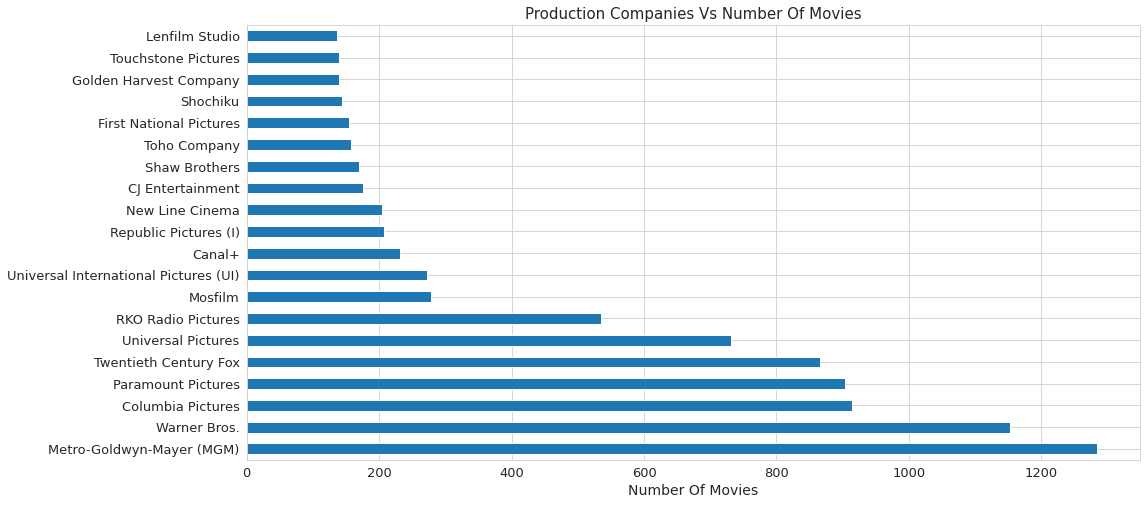

In [ ]:
import seaborn as sns

def count_genre(x):
    #concatenate all the rows of the genrs.
    data_plot = imdb_movies[x].str.cat(sep = '|')
    data = pd.Series(data_plot.split('|'))
    #conts each of the genre and return.
    info = data.value_counts(ascending=False)
    return info

#Firmy produkując najwiecej filmów - 20 największych
production_company = count_genre('production_company')

#plot he barh plot.
production_company.iloc[:20].plot(kind='barh',figsize=(16,8),fontsize=13)
plt.title("Production Companies Vs Number Of Movies",fontsize=15)
plt.xlabel('Number Of Movies',fontsize=14)
sns.set_style("whitegrid")

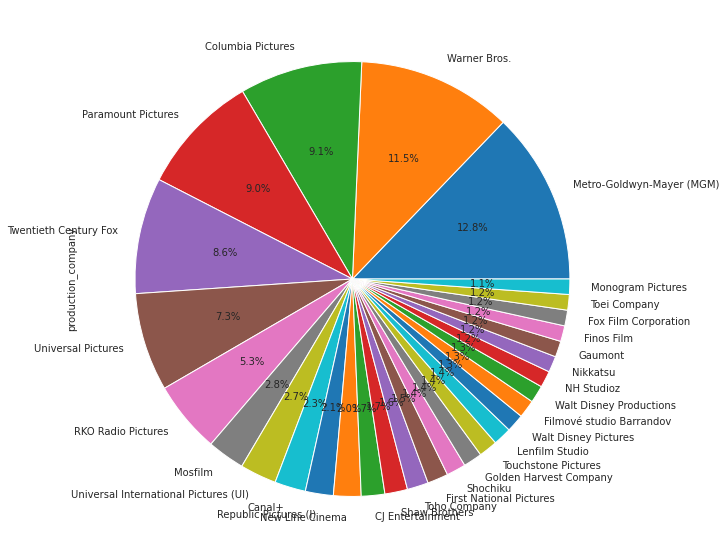

In [ ]:
imdb_movies.production_company.value_counts()[:30].plot.pie(autopct='%1.1f%%',figsize=(10,10))

In [ ]:
#Ile razy średnio są oceniane filmy danej firmy produkującej - popularność
df = imdb_movies.groupby('production_company')
df1 = df['reviews_from_users'].mean()
df1.sort_values(ascending = False, inplace = True)
top10production_users = df1.head(10)
print(top10production_users)

production_company
Three's Company Production    5261.000000
Avi Arad Productions          3632.000000
Monkeypaw Productions         3082.000000
Bay Films                     2298.000000
Marvel Studios                2285.750000
KatzSmith Productions         2231.000000
Lucasfilm                     2202.545455
Lava Bear Films               1875.000000
Haxan Films                   1786.000000
Syncopy                       1763.500000
Name: reviews_from_users, dtype: float64


In [ ]:
#Średnia ilość ocen krytyków filmów danej firmy produkującej
df = imdb_movies.groupby('production_company')
df1 = df['reviews_from_critics'].mean()
df1.sort_values(ascending = False, inplace = True)
top10production_critics = df1.head(10)
print(top10production_critics)

production_company
Double Dare You (DDY)      731.000000
Lava Bear Films            725.000000
Visiona Romantica          696.000000
B24                        643.000000
Marvel Studios             621.916667
Cottonwood Pictures        616.000000
Marvel Entertainment       614.000000
Monkeypaw Productions      527.000000
Cloud Atlas Productions    523.000000
EFTI                       496.000000
Name: reviews_from_critics, dtype: float64


In [ ]:
#Firmy produkujące - liczba wyprodukowaych filmów oraz średnia ocen tych filmów dla firm z powyżej 5 filmów
imdb_companies_av_votes=imdb_movies[['production_company','avg_vote']].groupby('production_company').agg(['count', 'mean']).reset_index()
imdb_companies_av_votes[imdb_companies_av_votes['avg_vote']['count']>5].sort_values(by=('avg_vote','mean'), ascending=False).reset_index().head(10)

index           production_company avg_vote          
                                         count      mean
0  22021             National Theatre       11  8.345455
1  30808              Vijaya Pictures        6  8.333333
2  22022        National Theatre Live        7  8.328571
3  24209   Poornodaya Movie Creations        6  8.283333
4  28080          StarKid Productions        6  8.016667
5   7101  Charles Chaplin Productions       11  7.972727
6   3671               Azerbaijanfilm       32  7.950000
7   2960                  Art Film 80        7  7.942857
8  26090                 Rupam Chitra        6  7.916667
9   4913        Bimal Roy Productions        6  7.883333

#Głosy -najczęściej oceniane filmy, korelacja budżetu ze średnią głosów, korelacja przychodu ze średnią głosów - przychodu w USA i na świecie - KASIA

In [167]:
imdb_votes = imdb_movies_all_USD = imdb_movies[imdb_movies.currency_for_usaincome.eq('$') & imdb_movies.currency_for_wwincome.eq('$') & imdb_movies.currency_for_budget.eq('$')]
imdb_votes = imdb_votes[['title', 'avg_vote', 'votes', 'budget', 'worlwide_gross_income', 'reviews_from_users', 'reviews_from_critics']]
imdb_votes.head()

,title,avg_vote,votes,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics
0,Miss Jerry,5.9,154,0,0,1.0,2.0
1,The Story of the Kelly Gang,6.1,589,2250,0,7.0,7.0
2,Den sorte drøm,5.8,188,0,0,5.0,2.0
3,Cleopatra,5.2,446,45000,0,25.0,3.0
4,L'Inferno,7.0,2237,0,0,31.0,14.0


In [168]:
##do uzupełnienia z grześka kodu - powiększyć, kolory
imdb_corr=imdb_votes.corr()
imdb_corr

,avg_vote,votes,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics
avg_vote,1.000000,0.169033,0.074939,0.100120,0.139810,0.199344
votes,0.169033,1.000000,0.582844,0.679209,0.767166,0.679406
budget,0.074939,0.582844,1.000000,0.774506,0.587685,0.635221
worlwide_gross_income,0.100120,0.679209,0.774506,1.000000,0.644624,0.592100
reviews_from_users,0.139810,0.767166,0.587685,0.644624,1.000000,0.676933
reviews_from_critics,0.199344,0.679406,0.635221,0.592100,0.676933,1.000000


<function seaborn.matrix.heatmap>

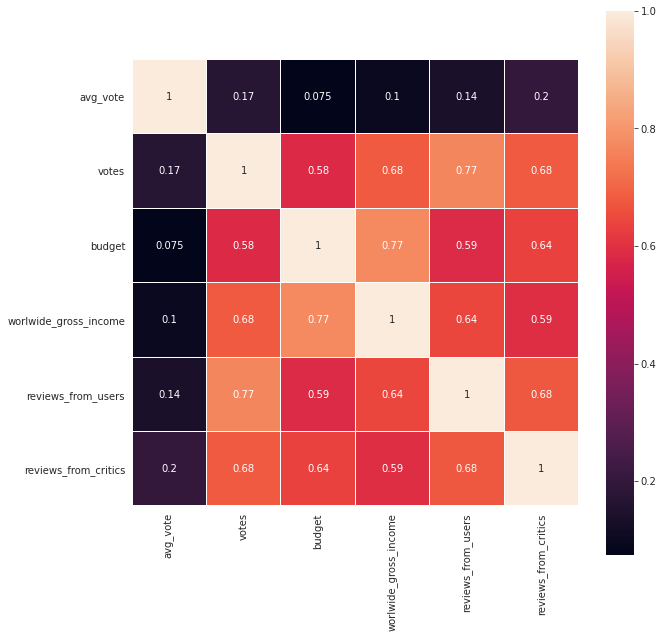

In [169]:
plt.figure(figsize=(10,10))
sn.heatmap(imdb_corr,annot=True,linewidths=0.01,vmax=1,square=True,cbar=True);
sn.heatmap

# Chmura słów z opisów filmów - EWA

In [170]:
imdb_movies['description'] = imdb_movies['description'].astype('str')
text = ' '.join(imdb_movies["description"])

In [171]:
text[:300]

"The adventures of a female reporter in the 1890s. True story of notorious Australian outlaw Ned Kelly (1855-80). Two men of high rank are both wooing the beautiful and famous equestrian acrobat Stella. While Stella ignores the jeweler Hirsch, she accepts Count von Waldberg's offer to follow her home"

(-0.5, 799.5, 599.5, -0.5)

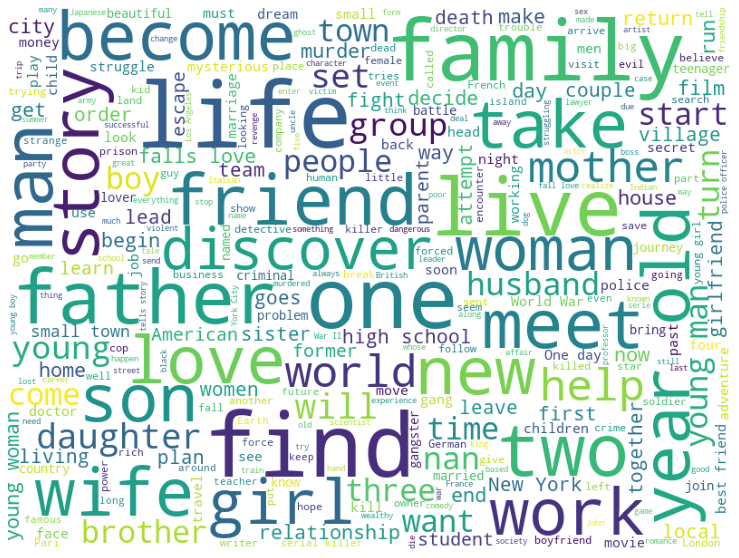

In [172]:
wc = WordCloud(max_words=300, width=800, height=600, max_font_size=100, background_color="white")

# generate word cloud
wc.generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis("off")

#Machine Learning

##Pobranie i rozpakowanie danych kaggle - MovieLens

In [173]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

100% 195M/195M [00:01<00:00, 82.3MB/s]



In [174]:
!unzip -q movielens-20m-dataset.zip -d CodersCrew

In [176]:
movielens_movies = pd.read_csv('/content/gdrive/MyDrive/CodersCrew/CodersCrew/movie.csv')
movielens_ratings = pd.read_csv('/content/gdrive/MyDrive/CodersCrew/CodersCrew/rating.csv')

In [177]:
movielens_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [178]:
movielens_movies.shape

(27278, 3)

In [179]:
movielens_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [180]:
movielens_ratings.shape

(20000263, 4)

##Łączenie datasetów - IMDb i MovieLens

In [181]:
# tworzę nową kolumnę z tytułem i rokiem produkcji w nawiasie

imdb_movies['title_year'] = imdb_movies.apply(lambda row: row.title + " (" + str(row.year) + ")", axis=1)
imdb_movies['title_year']

0                            Miss Jerry (1894)
1           The Story of the Kelly Gang (1906)
2                        Den sorte drøm (1911)
3                             Cleopatra (1912)
4                             L'Inferno (1911)
                         ...                  
85850                           Le lion (2020)
85851    De Beentjes van Sint-Hildegard (2020)
85852         Padmavyuhathile Abhimanyu (2019)
85853                 Sokagin Çocuklari (2019)
85854        La vida sense la Sara Amat (2019)
Name: title_year, Length: 85855, dtype: object

In [182]:
# muszę nadać taką samą nazwę (title_year) dla kolumny w movielens, wg której chcę łączyć

movielens_movies.columns = ['movieId', 'title_year', 'genres']

In [183]:
movies_merged_by_title = pd.merge(movielens_movies, imdb_movies, on='title_year')
movies_merged_by_title.shape

(5598, 33)

In [184]:
# spróbuję jeszcze z 'orginal_title' połączyć z rokiem produkcji w nawiasie

imdb_movies['title_year'] = imdb_movies.apply(lambda row: row.original_title + " (" + str(row.year) + ")", axis=1)
movies_merged_by_original_title = pd.merge(movielens_movies, imdb_movies, on='title_year')
movies_merged_by_original_title.shape

(11935, 33)

In [185]:
# ze względu na większą liczbę pokrywających się tytułów, decyduję się na połączenie baz wg 'original_title'

movies_merged = movies_merged_by_original_title[['movieId', 'title_year']]
movies_merged

,movieId,title_year
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
11930,131168,Phoenix (2014)
11931,131170,Parallels (2015)
11932,131174,Gentlemen (2014)
11933,131231,Standby (2014)


In [186]:
# tworzę listę id filmów z movies_merged (z powtórzeniami, bo to bez znaczenia) 
list_of_Ids_merged_movies = movies_merged.movieId.tolist()

# tworzę skorygowaną tabelę z ocenami użytkowników tak, aby występowały w niej oceny tylko tych filmów, które nas interesują
movielens_ratings_corrected = movielens_ratings[movielens_ratings['movieId'].isin(list_of_Ids_merged_movies)][['userId', 'movieId', 'rating']]

movielens_ratings_corrected.shape

(13435892, 3)

In [187]:
movielens_ratings_corrected.head()

,userId,movieId,rating
0,1,2,3.5
6,1,151,4.0
7,1,223,4.0
8,1,253,4.0
11,1,296,4.0


In [ ]:
# movielens_ratings_corrected.to_csv('/content/gdrive/My Drive/CodersCrew/ratings_to_pick_out')

##Dataframe z wylosowanymi danymi by ograniczyć zużycie pamięci przy trenowaniu modelu

In [319]:
sample_ratings = pd.read_csv('/content/gdrive/MyDrive/CodersCrew/sample_ratings_nowe.csv')

In [320]:
print('Min value: ' + str(sample_ratings.rating.min()))
print('Max value: ' + str(sample_ratings.rating.max()))

Min value: 0.5
Max value: 5.0


In [206]:
reader = Reader(rating_scale=(0, 5))

In [207]:
data = Dataset.load_from_df(sample_ratings[['userId', 'movieId', 'rating']], reader)

In [208]:
trainsetfull = data.build_full_trainset()
print('Number of users: ', trainsetfull.n_users, '\n')
print('Number of items: ', trainsetfull.n_items, '\n')

Number of users:  599 

Number of items:  4612 



In [312]:
##KNNBasic
algo_basic = KNNBasic(sim_options={
        'name': 'cosine',
        'user_based': False
        })
results = cross_validate(
    algo = algo_basic, data = data, measures=['RMSE'], 
    cv=5, return_train_measures=True
    )
    
print(results['test_rmse'].mean())

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
0.9918022257387807


In [321]:
##KNNWithMeans
my_k = 15
my_min_k = 5
my_sim_option = {
    'name':'pearson', 'user_based':True
    }

algo = KNNWithMeans(
    k = my_k, min_k = my_min_k, 
    sim_options = my_sim_option, verbose = True
    )
    
results = cross_validate(
    algo = algo, data = data, measures=['RMSE'], 
    cv=5, return_train_measures=True
    )
    
print(results['test_rmse'].mean())

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.9319308125726963


In [322]:
algo.fit(trainsetfull)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [323]:
algo.compute_similarities()

Computing the pearson similarity matrix...
Done computing similarity matrix.


array([[ 1.        , -0.09128709,  0.28524521, ...,  0.        ,
        -0.13952023,  0.5       ],
       [-0.09128709,  1.        , -0.13483997, ...,  0.        ,
        -0.46442036,  0.        ],
       [ 0.28524521, -0.13483997,  1.        , ...,  0.        ,
         0.15900143, -0.41026434],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.13952023, -0.46442036,  0.15900143, ...,  0.        ,
         1.        , -1.        ],
       [ 0.5       ,  0.        , -0.41026434, ...,  0.        ,
        -1.        ,  1.        ]])

In [324]:
list_of_Idsmovies = []

for i in range(0,len(sample_ratings['movieId']-1)):
  if sample_ratings['movieId'][i] not in list_of_Idsmovies:
    list_of_Idsmovies.append(sample_ratings['movieId'][i])

list_of_Idsmovies[:10]

[2, 151, 223, 253, 296, 337, 541, 589, 924, 1009]

In [325]:
def gimmie_recommendations(userId, num_of_movies = 10):
    
    if userId in list(sample_ratings.userId):
    
        predictions = {}
    
        for i in range(0,len(list_of_Idsmovies)-1):
            predictions[list_of_Idsmovies[i]] = algo.predict(userId, list_of_Idsmovies[i]).est

        sorted_predictions = sorted(predictions.values(), reverse=True)
        recommendations_ids = {}
    
        for i in sorted_predictions:
            for k in predictions.keys():
                if predictions[k] == i:
                    recommendations_ids[k] = predictions[k] 

        watched_movies_id=list(sample_ratings[sample_ratings.userId==1].movieId)
        for movie_id in watched_movies_id:
            if movie_id in recommendations_ids.keys():
                recommendations_ids.pop(movie_id)

        best_recommendations_ids = list(recommendations_ids.keys())[:num_of_movies+1]
        recommendations = []

        for j in range(0, len(best_recommendations_ids)-1):
            for i in range(0, len(movies_merged)-1):
                if movies_merged['movieId'][i] == best_recommendations_ids[j]:
                    recommendations.append(movies_merged['title_year'][i])

        return recommendations
    else:
        return 'User not in base'

In [326]:
def what_I_watched(userId):
    watched_movies_id=list(sample_ratings[sample_ratings.userId==userId].movieId)
    watched_movies=[]
    for j in range(0, len(watched_movies_id)-1):
        for i in range(0, len(movies_merged)-1):
            if movies_merged['movieId'][i] == watched_movies_id[j]:
                watched_movies.append(movies_merged['title_year'][i])
    return watched_movies

In [327]:
gimmie_recommendations(599, 10)

['Drive (2011)',
 'Ravenous (1999)',
 "It's a Wonderful Life (1946)",
 "Schindler's List (1993)",
 'Cool Hand Luke (1967)',
 'Primer (2004)',
 'Double Indemnity (1944)',
 'Cashback (2006)',
 'Back to the Future Part II (1989)',
 'Short Cuts (1993)']

In [329]:
what_I_watched(599)[:10]

['Copycat (1995)',
 'Under Siege 2: Dark Territory (1995)',
 'Naked Gun 33 1/3: The Final Insult (1994)',
 'Hot Shots! Part Deux (1993)',
 'Striptease (1996)',
 'Tin Cup (1996)',
 'Cool Hand Luke (1967)',
 'Star Trek VI: The Undiscovered Country (1991)',
 'Star Trek III: The Search for Spock (1984)',
 'Deep Impact (1998)']

In [316]:
gimmie_recommendations(220, 10)

["No Man's Land (2001)",
 'Ravenous (1999)',
 'Annie Hall (1977)',
 'American Beauty (1999)',
 'Goodfellas (1990)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
 'Before Sunset (2004)',
 'Forrest Gump (1994)',
 'City Lights (1931)',
 "Sullivan's Travels (1941)"]

In [318]:
what_I_watched(220)[:20]

['Toy Story (1995)',
 'Jumanji (1995)',
 'Heat (1995)',
 'Casino (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Braveheart (1995)',
 'Apollo 13 (1995)',
 'Nine Months (1995)',
 'Before Sunrise (1995)',
 'Clerks (1994)',
 'Pulp Fiction (1994)',
 'Quiz Show (1994)',
 'Forrest Gump (1994)',
 'Naked Gun 33 1/3: The Final Insult (1994)',
 "Carlito's Way (1993)",
 'Dazed and Confused (1993)',
 'Hot Shots! Part Deux (1993)',
 'Jurassic Park (1993)',
 'Searching for Bobby Fischer (1993)']